# 제주도 버스승차 인원 예측
- ## data 415423 rows × 21 columns
### train columns
- id : 해당 데이터에서의 고유한 id
- data : 날짜
- bus_route_id : 노선 ID
- in_out : 시내버스, 시외버스 구분
- station_code : 해당 승하차 정류소의 id
- station_name : 해당 승하차 정류소의 이름
- latitude : 해당 버스정류장의 위도
- longitude : 해당 버스정류장의 경도
- X-Y_ride : X:00:00 ~ x:59:59까지 승차한 인원 수
- X-Y_takeoff : X:00:00 ~ x:59:59까지 하차한 인원 수
- 18-20_ride : 18:00:00부터 19:59:59까지 승차한 인원 수

In [55]:
# 추가되는 패키지는 여기에서 import 해주세요
import warnings
warnings.filterwarnings('ignore')

import missingno
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import geopy.distance
pd.set_option('display.max_colwidth', -1)

import numpy as np
import datetime
import statsmodels.api as sm

In [3]:
# 데이터 load
train = pd.read_csv('train.csv', date_parser='date')
train.tail()

id        date  bus_route_id in_out  station_code  station_name  \
415418  415418  2019-09-30  32820000      시내     1129          한림환승정류장(한림리)   
415419  415419  2019-09-30  32820000      시내     1564          제주시외버스터미널      
415420  415420  2019-09-30  32820000      시내     2322          해병부대           
415421  415421  2019-09-30  32820000      시내     3291          애월환승정류장(애월리)   
415422  415422  2019-09-30  32820000      시내     6115100       서귀포시외버스터미널     

        latitude  longitude  6~7_ride  7~8_ride     ...      9~10_ride  \
415418  33.41437  126.26336  4.0       0.0          ...      0.0         
415419  33.49946  126.51479  4.0       0.0          ...      0.0         
415420  33.23100  126.26273  0.0       0.0          ...      0.0         
415421  33.46483  126.31870  1.0       0.0          ...      0.0         
415422  33.24873  126.50799  0.0       0.0          ...      0.0         

        10~11_ride  11~12_ride  6~7_takeoff  7~8_takeoff  8~9_takeoff  \
415418  0.0         0.0         0.0          0.0          0.0           
415419  0.0         0.0         0.0          0.0          0.0           
415420  0.0         0.0         0.0          1.0          0.0           
415421  0.0         0.0         0.0          0.0          0.0           
415422  0.0         0.0         0.0          0.0          4.0           

        9~10_takeoff  10~11_takeoff  11~12_takeoff  18~20_ride  
415418  0.0           0.0            0.0            0.0         
415419  0.0           0.0            0.0            0.0         
415420  0.0           0.0            0.0            0.0         
415421  0.0           0.0            0.0            0.0         
415422  0.0           0.0            0.0            0.0         

[5 rows x 21 columns]

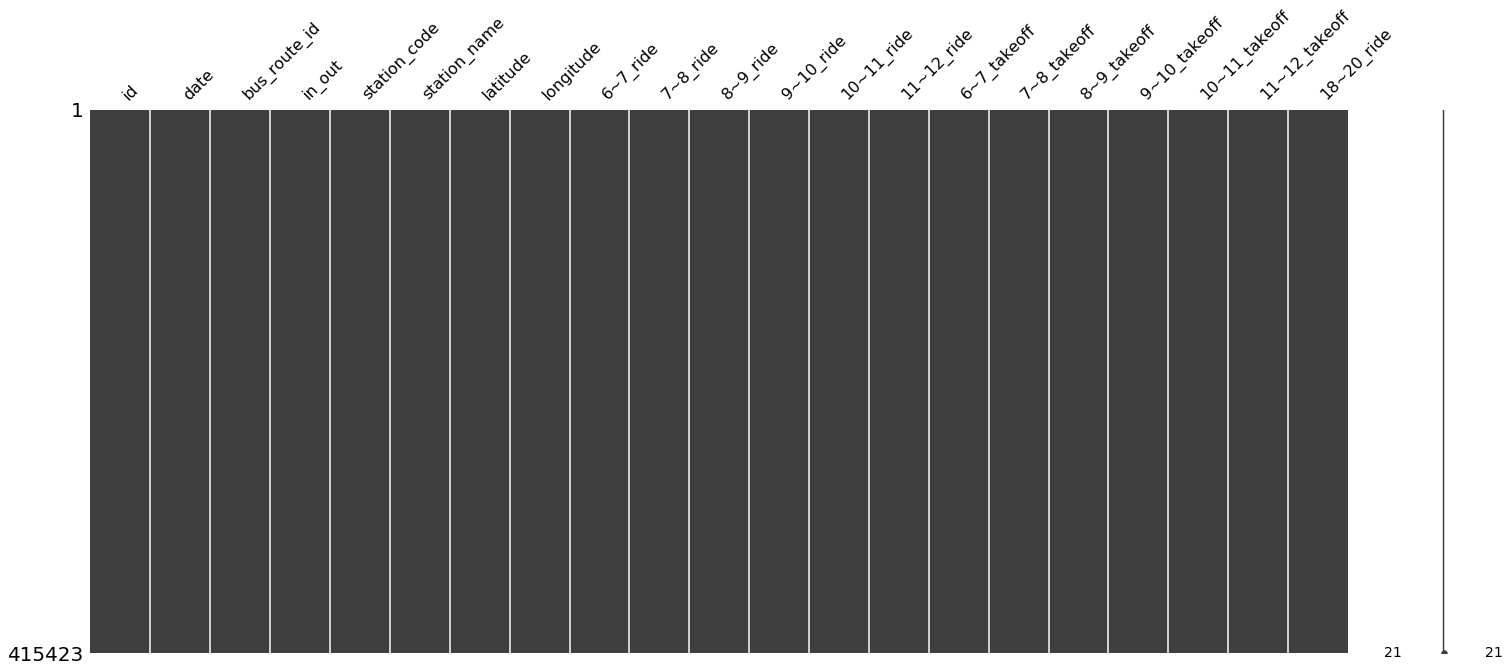

In [4]:
# Nan data 확인
# Nan data 없는것으로 확인
missingno.matrix(train)
plt.show()

In [5]:
# Nan값이 없는것을 알수 있다.
# 정확히 Nan값이 없는것을 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415423 entries, 0 to 415422
Data columns (total 21 columns):
id               415423 non-null int64
date             415423 non-null object
bus_route_id     415423 non-null int64
in_out           415423 non-null object
station_code     415423 non-null int64
station_name     415423 non-null object
latitude         415423 non-null float64
longitude        415423 non-null float64
6~7_ride         415423 non-null float64
7~8_ride         415423 non-null float64
8~9_ride         415423 non-null float64
9~10_ride        415423 non-null float64
10~11_ride       415423 non-null float64
11~12_ride       415423 non-null float64
6~7_takeoff      415423 non-null float64
7~8_takeoff      415423 non-null float64
8~9_takeoff      415423 non-null float64
9~10_takeoff     415423 non-null float64
10~11_takeoff    415423 non-null float64
11~12_takeoff    415423 non-null float64
18~20_ride       415423 non-null float64
dtypes: float64(15), int64(3), object

In [6]:
# 분석에 필요없는 컬럼 확인을 위해 컬럼 갯수 확인
for i in train.columns:
    print('{}의 갯수는 '.format(i),len(train[i].unique()))

id의 갯수는  415423
date의 갯수는  30
bus_route_id의 갯수는  613
in_out의 갯수는  2
station_code의 갯수는  3563
station_name의 갯수는  1961
latitude의 갯수는  3278
longitude의 갯수는  3446
6~7_ride의 갯수는  47
7~8_ride의 갯수는  80
8~9_ride의 갯수는  78
9~10_ride의 갯수는  66
10~11_ride의 갯수는  66
11~12_ride의 갯수는  69
6~7_takeoff의 갯수는  35
7~8_takeoff의 갯수는  51
8~9_takeoff의 갯수는  53
9~10_takeoff의 갯수는  46
10~11_takeoff의 갯수는  47
11~12_takeoff의 갯수는  55
18~20_ride의 갯수는  170


#### train column 의사결정
- id의 갯수는  415423개로 카테고리 변수이며 해당 변수를 분석에 사용할수 없어서 '삭제'
- date의 갯수는  30개로 카테고리 변수로 해당 변수를 분석에 사용 하기로 함 '킵'
    - 연도와 월은 2019년 9월만 있어서 의미가 없으나, 일과 요일은 사용할수 있을듯, 9월은 12,13,14가 추석임
    - 제주도는 관광도시로 추석에 인원이 더 많을수도 있음
- bus_route_id의 갯수는  613개로 카테고리 변수이며 해당 변수를 분석에 사용 할수는 없으나, 다른 분석에 쓰일수 있어서 '킵'
    - station_code별 bus_route_id의 갯수를 구하면 해당 정류장에 오는 버스노선의 수를 알수 있음.
- in_out의 갯수는  2개로 카테고리 변수이며, 해당 변수를 분석에 사용하기로 함 '킵'
    - 시내, 시외 비율 확인
- station_code의 갯수는  3563개로 카테고리 변수이며 분석에는 사용하지 않음
    - 정류소 구분을 위해 일단 킵
- station_name의 갯수는  1961개로 카테고리 변수이며 분석에는 사용하지 않음
    - 정류소 구분을 위해 일단 킵
- latitude의 갯수는  3278개로 위치정보이므로 일단 사용
    - 특정 지점을 기준하여 거리화 해보기
- longitude의 갯수는  3446개로 위치정보이므로 일단 사용
    - 특정 지점을 기준하여 거리화 해보기
- 6~7_ride의 갯수는  47 : 킵
    - 이하 말이 필요없음 무조건 킵
- 7~8_ride의 갯수는  80 : 킵
- 8~9_ride의 갯수는  78 : 킵
- 9~10_ride의 갯수는  66 : 킵
- 10~11_ride의 갯수는  66 : 킵
- 11~12_ride의 갯수는  69 : 킵
- 6~7_takeoff의 갯수는  35 : 킵
- 7~8_takeoff의 갯수는  51 : 킵
- 8~9_takeoff의 갯수는  53 : 킵
- 9~10_takeoff의 갯수는  46 : 킵
- 10~11_takeoff의 갯수는  47 : 킵
- 11~12_takeoff의 갯수는  55 : 킵
- 18~20_ride의 갯수는  170 : 킵

In [7]:
train.columns

Index(['id', 'date', 'bus_route_id', 'in_out', 'station_code', 'station_name',
       'latitude', 'longitude', '6~7_ride', '7~8_ride', '8~9_ride',
       '9~10_ride', '10~11_ride', '11~12_ride', '6~7_takeoff', '7~8_takeoff',
       '8~9_takeoff', '9~10_takeoff', '10~11_takeoff', '11~12_takeoff',
       '18~20_ride'],
      dtype='object')

In [8]:
# 분석에 완전히 필요없는 컬럼 id만 삭제
train.drop(['id'],axis=1,inplace=True)
train

date  bus_route_id in_out  station_code          station_name  \
0       2019-09-01  4270000       시외     344           제주썬호텔                  
1       2019-09-01  4270000       시외     357           한라병원                   
2       2019-09-01  4270000       시외     432           정존마을                   
3       2019-09-01  4270000       시내     1579          제주국제공항(600번)           
4       2019-09-01  4270000       시내     1646          중문관광단지입구               
5       2019-09-01  4270000       시내     1648          예래입구                   
6       2019-09-01  4270000       시외     1660          제주국제컨벤션센터중문대포해안주상절리대   
7       2019-09-01  4270000       시외     1666          창천리                    
8       2019-09-01  4270000       시외     1726          강정농협                   
9       2019-09-01  4270000       시내     2008          서귀포항                   
10      2019-09-01  4270000       시외     2009          뉴경남호텔                  
11      2019-09-01  4270000       시내     2013          신라호텔                   
12      2019-09-01  4270000       시외     2014          하얏트호텔                  
13      2019-09-01  4270000       시외     2094          한국콘도입구                 
14      2019-09-01  4270000       시외     2095          켄싱턴제주호텔입구              
15      2019-09-01  4270000       시외     2114          스위트호텔                  
16      2019-09-01  4270000       시내     2494          동광환승정류장5(서귀방면)         
17      2019-09-01  4270000       시외     2697          대포항                    
18      2019-09-01  4270000       시외     2699          약천사                    
19      2019-09-01  4270000       시내     2843          중문관광단지여미지식물원입구         
20      2019-09-01  4270000       시내     2851          제주월드컵경기장(600번)         
21      2019-09-01  4270000       시외     2885          월평마을                   
22      2019-09-01  4270000       시내     2966          롯데시티호텔(600번)           
23      2019-09-01  4270000       시내     3031          서귀포칼호텔(종점)             
24      2019-09-01  4270000       시내     4154          왕대왓                    
25      2019-09-01  4280000       시외     343           제주썬호텔                  
26      2019-09-01  4280000       시내     358           한라병원                   
27      2019-09-01  4280000       시내     431           정존마을                   
28      2019-09-01  4280000       시내     1636          롯데호텔                   
29      2019-09-01  4280000       시내     1645          중문관광단지입구               
...            ...      ...       ..      ...               ...               
415393  2019-09-30  32760000      시내     122           인다마을                   
415394  2019-09-30  32760000      시내     129           제주의료원                  
415395  2019-09-30  32760000      시내     136           산천단한국폴리텍대학             
415396  2019-09-30  32760000      시내     147           용천마을                   
415397  2019-09-30  32760000      시내     164           광양사거리                  
415398  2019-09-30  32760000      시내     1261          교래리                    
415399  2019-09-30  32760000      시내     1629          붉은오름휴양림입구              
415400  2019-09-30  32760000      시내     2522          남원읍사무소                 
415401  2019-09-30  32760000      시내     2645          디삘레                    
415402  2019-09-30  32760000      시내     2650          의귀교회앞                  
415403  2019-09-30  32760000      시내     2651          의귀환승정류장(의귀초등학교)        
415404  2019-09-30  32760000      시내     2969          제주버스터미널(종점)            
415405  2019-09-30  32760000      시내     3271          제주시청(광양방면)             
415406  2019-09-30  32760000      시내     3273          고산동산(광양방면)             
415407  2019-09-30  32760000      시내     3275          제주지방법원(광양방면)           
415408  2019-09-30  32760000      시내     3279          제주여자중고등학교(광양방면)        
415409  2019-09-30  32760000      시내     3281          남국원(광양방면)              
415410  2019-09-30  32760000      시내     3289          남원환승정류장(남원읍사무소)        
415411  2019-09-30  32810000      시내     1129          한림환승정류장(한

In [9]:
# 분석을 위해 컬럼명 수정
train.rename(columns={'6~7_ride': 'ride6', '7~8_ride': 'ride7', '8~9_ride': 'ride8',\
                      '9~10_ride': 'ride9', '10~11_ride': 'ride10', '11~12_ride': 'ride11', 
                      '6~7_takeoff': 'off6', '7~8_takeoff': 'off7', '8~9_takeoff': 'off8', \
                      '9~10_takeoff': 'off9', '10~11_takeoff': 'off10', '11~12_takeoff': 'off11',\
                      '18~20_ride': 'ride18'},inplace=True)
train

date  bus_route_id in_out  station_code          station_name  \
0       2019-09-01  4270000       시외     344           제주썬호텔                  
1       2019-09-01  4270000       시외     357           한라병원                   
2       2019-09-01  4270000       시외     432           정존마을                   
3       2019-09-01  4270000       시내     1579          제주국제공항(600번)           
4       2019-09-01  4270000       시내     1646          중문관광단지입구               
5       2019-09-01  4270000       시내     1648          예래입구                   
6       2019-09-01  4270000       시외     1660          제주국제컨벤션센터중문대포해안주상절리대   
7       2019-09-01  4270000       시외     1666          창천리                    
8       2019-09-01  4270000       시외     1726          강정농협                   
9       2019-09-01  4270000       시내     2008          서귀포항                   
10      2019-09-01  4270000       시외     2009          뉴경남호텔                  
11      2019-09-01  4270000       시내     2013          신라호텔                   
12      2019-09-01  4270000       시외     2014          하얏트호텔                  
13      2019-09-01  4270000       시외     2094          한국콘도입구                 
14      2019-09-01  4270000       시외     2095          켄싱턴제주호텔입구              
15      2019-09-01  4270000       시외     2114          스위트호텔                  
16      2019-09-01  4270000       시내     2494          동광환승정류장5(서귀방면)         
17      2019-09-01  4270000       시외     2697          대포항                    
18      2019-09-01  4270000       시외     2699          약천사                    
19      2019-09-01  4270000       시내     2843          중문관광단지여미지식물원입구         
20      2019-09-01  4270000       시내     2851          제주월드컵경기장(600번)         
21      2019-09-01  4270000       시외     2885          월평마을                   
22      2019-09-01  4270000       시내     2966          롯데시티호텔(600번)           
23      2019-09-01  4270000       시내     3031          서귀포칼호텔(종점)             
24      2019-09-01  4270000       시내     4154          왕대왓                    
25      2019-09-01  4280000       시외     343           제주썬호텔                  
26      2019-09-01  4280000       시내     358           한라병원                   
27      2019-09-01  4280000       시내     431           정존마을                   
28      2019-09-01  4280000       시내     1636          롯데호텔                   
29      2019-09-01  4280000       시내     1645          중문관광단지입구               
...            ...      ...       ..      ...               ...               
415393  2019-09-30  32760000      시내     122           인다마을                   
415394  2019-09-30  32760000      시내     129           제주의료원                  
415395  2019-09-30  32760000      시내     136           산천단한국폴리텍대학             
415396  2019-09-30  32760000      시내     147           용천마을                   
415397  2019-09-30  32760000      시내     164           광양사거리                  
415398  2019-09-30  32760000      시내     1261          교래리                    
415399  2019-09-30  32760000      시내     1629          붉은오름휴양림입구              
415400  2019-09-30  32760000      시내     2522          남원읍사무소                 
415401  2019-09-30  32760000      시내     2645          디삘레                    
415402  2019-09-30  32760000      시내     2650          의귀교회앞                  
415403  2019-09-30  32760000      시내     2651          의귀환승정류장(의귀초등학교)        
415404  2019-09-30  32760000      시내     2969          제주버스터미널(종점)            
415405  2019-09-30  32760000      시내     3271          제주시청(광양방면)             
415406  2019-09-30  32760000      시내     3273          고산동산(광양방면)             
415407  2019-09-30  32760000      시내     3275          제주지방법원(광양방면)           
415408  2019-09-30  32760000      시내     3279          제주여자중고등학교(광양방면)        
415409  2019-09-30  32760000      시내     3281          남국원(광양방면)              
415410  2019-09-30  32760000      시내     3289          남원환승정류장(남원읍사무소)        
415411  2019-09-30  32810000      시내     1129          한림환승정류장(한

In [10]:
# 시작 날짜와, 끝 날짜 확인
print(train['date'].min())
print(train['date'].max())

2019-09-01
2019-09-30


In [11]:
# date 타입 변경
train['date'] = train['date'].astype('datetime64')
# 9월 1일 ~ 9월 30일 데이터이니까, day만 따로 가져옴
train['date_day'] = train['date'].dt.day
# 월(0) ~ 일(6) 데이터로 변환
train['date_dayofweek'] = train['date'].dt.dayofweek
train['date_dayofname']= train['date'].dt.weekday_name
train[['date','date_dayofweek','date_day','date_dayofname']]

date  date_dayofweek  date_day date_dayofname
0      2019-09-01  6               1         Sunday       
1      2019-09-01  6               1         Sunday       
2      2019-09-01  6               1         Sunday       
3      2019-09-01  6               1         Sunday       
4      2019-09-01  6               1         Sunday       
5      2019-09-01  6               1         Sunday       
6      2019-09-01  6               1         Sunday       
7      2019-09-01  6               1         Sunday       
8      2019-09-01  6               1         Sunday       
9      2019-09-01  6               1         Sunday       
10     2019-09-01  6               1         Sunday       
11     2019-09-01  6               1         Sunday       
12     2019-09-01  6               1         Sunday       
13     2019-09-01  6               1         Sunday       
14     2019-09-01  6               1         Sunday       
15     2019-09-01  6               1         Sunday       
16     2019-09-01  6               1         Sunday       
17     2019-09-01  6               1         Sunday       
18     2019-09-01  6               1         Sunday       
19     2019-09-01  6               1         Sunday       
20     2019-09-01  6               1         Sunday       
21     2019-09-01  6               1         Sunday       
22     2019-09-01  6               1         Sunday       
23     2019-09-01  6               1         Sunday       
24     2019-09-01  6               1         Sunday       
25     2019-09-01  6               1         Sunday       
26     2019-09-01  6               1         Sunday       
27     2019-09-01  6               1         Sunday       
28     2019-09-01  6               1         Sunday       
29     2019-09-01  6               1         Sunday       
...           ... ..              ..            ...       
415393 2019-09-30  0               30        Monday       
415394 2019-09-30  0               30        Monday       
415395 2019-09-30  0               30        Monday       
415396 2019-09-30  0               30        Monday       
415397 2019-09-30  0               30        Monday       
415398 2019-09-30  0               30        Monday       
415399 2019-09-30  0               30        Monday       
415400 2019-09-30  0               30        Monday       
415401 2019-09-30  0               30        Monday       
415402 2019-09-30  0               30        Monday       
415403 2019-09-30  0               30        Monday       
415404 2019-09-30  0               30        Monday       
415405 2019-09-30  0               30        Monday       
415406 2019-09-30  0               30        Monday       
415407 2019-09-30  0               30        Monday       
415408 2019-09-30  0               30        Monday       
415409 2019-09-30  0               30        Monday       
415410 2019-09-30  0               30        Monday       
415411 2019-09-30  0               30        Monday       
415412 2019-09-30  0               30        Monday       
415413 2019-09-30  0               30        Monday       
415414 2019-09-30  0               30        Monday       
415415 2019-09-30  0               30        Monday       
415416 2019-09-30  0               30        Monday       
415417 2019-09-30  0               30        Monday       
415418 2019-09-30  0               30        Monday       
415419 2019-09-30  0               30        Monday       
415420 2019-09-30  0               30        Monday       
415421 2019-09-30  0               30        Monday       
415422 2019-09-30  0               30        Monday       

[415423 rows x 4 columns]

In [12]:
# 추석 추가 컬럼명 : 'Thanksgiving_Day'
train['Thanksgiving_Day'] = 0
train.loc[train['date'] == '2019-09-14', 'Thanksgiving_Day'] = 1
train.loc[train['date'] == '2019-09-13', 'Thanksgiving_Day'] = 1
train.loc[train['date'] == '2019-09-12', 'Thanksgiving_Day'] = 1
print(train['Thanksgiving_Day'].sum())
# 제대로 바뀌었는지 확인
train[train['date'] == '2019-09-14'].count()[0] + \
train[train['date'] == '2019-09-12'].count()[0] + \
train[train['date'] == '2019-09-13'].count()[0]

30719


30719

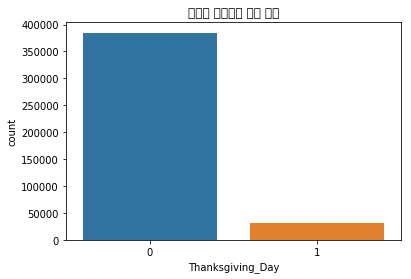

In [13]:
sns.countplot(data=train, x= 'Thanksgiving_Day')
plt.title('추석과 아닌날의 탑승 비율')
plt.show()

In [14]:
# 추석 3일동안 버스 이용률이 전체의 7.4%임
train['Thanksgiving_Day'].value_counts() / train['Thanksgiving_Day'].value_counts().sum() * 100

0    92.605369
1    7.394631 
Name: Thanksgiving_Day, dtype: float64

In [15]:
pd.set_option('display.max_colwidth', -1)

In [16]:
train.columns

Index(['date', 'bus_route_id', 'in_out', 'station_code', 'station_name',
       'latitude', 'longitude', 'ride6', 'ride7', 'ride8', 'ride9', 'ride10',
       'ride11', 'off6', 'off7', 'off8', 'off9', 'off10', 'off11', 'ride18',
       'date_day', 'date_dayofweek', 'date_dayofname', 'Thanksgiving_Day'],
      dtype='object')

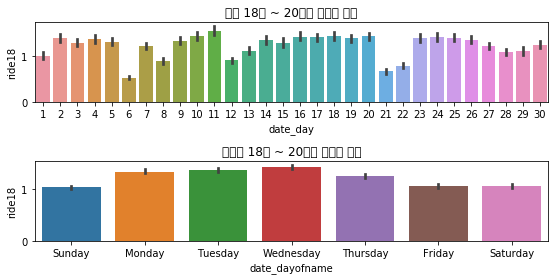

In [17]:
# 일별, 요일별 탑승한 인원 그래프
plt.figure(figsize=(8, 4))
plt.subplot(211)
plt.title('일별 18시 ~ 20시에 탑승한 인원')
sns.barplot(x='date_day', y='ride18', data=train)

plt.subplot(212)
plt.title('요일별 18시 ~ 20시에 탑승한 인원')
sns.barplot(x='date_dayofname', y='ride18', data=train)
plt.tight_layout()
plt.show()

#### 9월6일 : 제주도 태풍 링링

In [18]:
#6일, 8일, 12일, 21일, 22일 확인 필요 : 금,일,목,토,일

print(train[train['date_day']==6]['date_dayofname'].head(1))
print(train[train['date_day']==8]['date_dayofname'].head(1))
print(train[train['date_day']==12]['date_dayofname'].head(1))
print(train[train['date_day']==21]['date_dayofname'].head(1))
print(train[train['date_day']==22]['date_dayofname'].head(1))


72428    Friday
Name: date_dayofname, dtype: object
97978    Sunday
Name: date_dayofname, dtype: object
156277    Thursday
Name: date_dayofname, dtype: object
277476    Saturday
Name: date_dayofname, dtype: object
289010    Sunday
Name: date_dayofname, dtype: object


In [19]:
result  = sm.OLS.from_formula('ride18~ + C(date_dayofname)', data = train).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                 ride18   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     71.69
Date:                Tue, 24 Mar 2020   Prob (F-statistic):           1.03e-89
Time:                        00:28:41   Log-Likelihood:            -1.2341e+06
No. Observations:              415423   AIC:                         2.468e+06
Df Residuals:                  415416   BIC:                         2.468e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

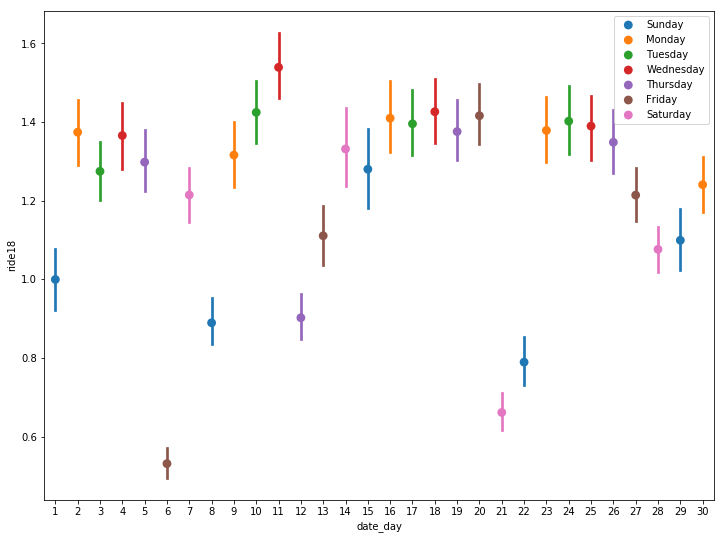

In [20]:
# 아래 그래프는 pointplot인데, 이상하게 나옴. 필요없으면 삭제하셔도 무방
plt.figure(figsize=(12,9))
sns.pointplot(data=train, x='date_day', y='ride18',hue='date_dayofname',linestyles='-') 
plt.legend()
plt.show()

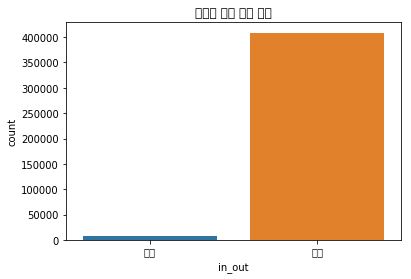

In [21]:
# 시내와 시외 탑승비율
# 제주도의 시는 제주시와 서귀포시를 의미.
# 시외버스는 거의 없다는것을 알수있고, 제주도의 시외버스터미널은 제주시와 서귀포시에 각 한개씩 있음.
# 이자료를 비추어보아, 위도경도를 거리화 할때 제주시와 서귀포시를 나누는것은 의미있을수도 있음.
sns.countplot(data=train, x= 'in_out')
plt.title('시내와 시외 탑승 비율')
plt.show()

In [22]:
# 시내와 시외버스 비율 약 98.3과 1.7
train['in_out'].value_counts() / train['in_out'].value_counts().sum() * 100

시내    98.333506
시외    1.666494 
Name: in_out, dtype: float64

### 승하차 인원 분석

In [23]:
# 승하차 인원 피봇테이블 생성
values = ['ride6', 'ride7', 'ride8',
          'ride9', 'ride10', 'ride11', 'off6', 'off7', 'off8', 'off9', 'off10',
          'off11', 'ride18']
values_ride = ['ride6', 'ride7', 'ride8',
               'ride9', 'ride10', 'ride11']
values_off = ['off6', 'off7', 'off8', 'off9', 'off10',
              'off11']

table_all = pd.pivot_table(train, index='station_name', aggfunc=sum, values=values)
table_ride = pd.pivot_table(train, index='station_name', aggfunc=sum, values=values_ride)
table_off = pd.pivot_table(train, index='station_name', aggfunc=sum, values=values_off)
table_ride18 = pd.pivot_table(train, index='station_name', aggfunc=sum, values='ride18')

In [24]:
# 전체 승하차 인원 분석
table_all['all'] = table_all.sum(axis = 1)
table_all['percent'] = table_all['all'] / table_all['all'].sum() * 100
table_all

off10  off11   off6   off7   off8   off9  ride10  ride11  \
station_name                                                                
(구)구판장           5.0    9.0    0.0    0.0    1.0    0.0    11.0    0.0      
(구)중문동주민센터       139.0  70.0   12.0   79.0   138.0  131.0  128.0   121.0    
(구)중앙파출소         288.0  322.0  71.0   183.0  412.0  316.0  311.0   225.0    
(구)화산초등학교        6.0    1.0    0.0    0.0    0.0    0.0    0.0     0.0      
1100고지휴게소        16.0   12.0   0.0    0.0    20.0   7.0    10.0    24.0     
1100도로입구         0.0    0.0    6.0    6.0    3.0    1.0    126.0   86.0     
4.3평화공원          28.0   18.0   3.0    38.0   10.0   43.0   0.0     30.0     
4.3평화공원입구        4.0    1.0    0.0    7.0    3.0    2.0    1.0     0.0      
6호광장             30.0   28.0   3.0    26.0   43.0   31.0   70.0    83.0     
911의원            18.0   13.0   3.0    10.0   10.0   11.0   20.0    19.0     
GM빌라             5.0    16.0   3.0    15.0   20.0   18.0   28.0    42.0     
KIS빌리지           3.0    3.0    0.0    0.0    0.0    1.0    3.0     4.0      
LH12단지           26.0   38.0   18.0   71.0   87.0   40.0   132.0   104.0    
LH아파트            69.0   65.0   6.0    42.0   56.0   41.0   135.0   138.0    
L마트              180.0  205.0  3.0    60.0   77.0   134.0  114.0   63.0     
NHF삼화1단지         68.0   56.0   24.0   52.0   61.0   74.0   371.0   298.0    
NLCS제주           14.0   25.0   6.0    40.0   62.0   37.0   19.0    28.0     
S중앙병원            123.0  136.0  107.0  231.0  296.0  172.0  131.0   110.0    
가마초등학교           27.0   27.0   6.0    17.0   14.0   16.0   56.0    35.0     
가문동마을길           4.0    2.0    0.0    0.0    0.0    11.0   7.0     4.0      
가물개공원            9.0    2.0    0.0    2.0    0.0    6.0    24.0    17.0     
가시나물             14.0   8.0    1.0    67.0   91.0   20.0   45.0    61.0     
가시농협             16.0   21.0   0.0    3.0    0.0    12.0   28.0    14.0     
가시리              1.0    4.0    0.0    11.0   1.0    1.0    14.0    2.0      
가시리동상동           14.0   9.0    0.0    1.0    0.0    8.0    16.0    10.0     
가시리동하동           7.0    9.0    0.0    1.0    0.0    9.0    3.0     2.0      
가시리사무소           25.0   15.0   0.0    0.0    0.0    4.0    2.0     1.0      
가시리체육공원          6.0    1.0    0.0    0.0    0.0    4.0    0.0     0.0      
가원               1.0    6.0    0.0    5.0    27.0   9.0    4.0     8.0      
가흥동              19.0   23.0   9.0    29.0   12.0   8.0    19.0    11.0     
...              ...    ...    ...    ...     ...   ...    ...     ...      
화순생태탐방로          0.0    2.0    0.0    0.0    0.0    0.0    0.0     0.0      
화순해안경기안전센터사계출장소  1.0    0.0    0.0    1.0    0.0    2.0    2.0     3.0      
화순해안경비안전센터사계출장소  1.0    3.0    0.0    1.0    0.0    0.0    3.0     0.0      
화순환승정류장(안덕농협)    265.0  283.0  127.0  349.0  429.0  334.0  411.0   470.0    
화전마을             58.0   50.0   31.0   121.0  59.0   36.0   14.0    32.0     
환경시설관리소          2.0    2.0    3.0    6.0    4.0    5.0    0.0     1.0      
환상숲곶자왈공원         26.0   19.0   0.0    0.0    1.0    14.0   7.0     9.0      
활오름              0.0    4.0    0.0    1.0    2.0    0.0    2.0     3.0      
황사평              4.0    14.0   0.0    19.0   3.0    6.0    60.0    57.0     
황사평성지            2.0    8.0    9.0    10.0   9.0    3.0    3.0     9.0      
황사평입구            7.0    10.0   3.0    8.0    16.0   4.0    3.0     0.0      
황세왓동산            5.0    2.0    0.0    2.0    0.0    1.0    0.0     1.0      
회수동              7.0    10.0   0.0    0.0    3.0    1.0    15.0    10.0     
회수마을회관           92.0   82.0   0.0    9.0    33.0   38.0   146.0   83.0     
회수사거리            18.0   0.0    0.0    4.0    8.0    0.0    20.0    19.0     
회수삼거리            13.0   14.0   0.0    1.0    21.0   15.0   10.0    14.0     
회천입구             83.0   306.0  56.0   136.0  404.0  228.0  89.0    472.0    
효돈농협하나로마트        5.0    19.0   3.0    3.0    7.0    14.0   23.0    18.0     
효돈중학교            136.0  129.0  27.0   114.0  93.0   95.0   235.0   176.0    
효돈초등학교       

In [25]:
# 전체 승하차 인원이 가장 높은 10군데 정류장
# 하위는 ascending옵션을 지우시면 됨
table_all_top_10= table_all.sort_values(by='all',ascending = False)[:10]
table_all_top_10

off10   off11    off6    off7    off8    off9  ride10  ride11  \
station_name                                                                    
한라병원           3879.0  3182.0  1429.0  4026.0  6164.0  5063.0  5779.0  5464.0   
제주버스터미널        3617.0  4054.0  2063.0  3005.0  3665.0  3912.0  4147.0  3751.0   
제주시청(광양방면)     2677.0  2834.0  580.0   1519.0  2839.0  2537.0  3569.0  4019.0   
제주대학교          2360.0  1501.0  373.0   1584.0  3707.0  2184.0  2369.0  3342.0   
제주시청(아라방면)     2866.0  3054.0  993.0   2186.0  3319.0  3115.0  2955.0  2818.0   
제주도청신제주로터리     2128.0  2310.0  717.0   2249.0  4084.0  2517.0  3281.0  2859.0   
동문로터리(동문시장)    2866.0  2301.0  578.0   935.0   1672.0  2373.0  3465.0  4008.0   
노형오거리          1722.0  1460.0  410.0   1045.0  1868.0  1815.0  3209.0  3423.0   
제주시외버스터미널      63.0    66.0    26.0    67.0    150.0   78.0    3847.0  3111.0   
제주국제공항(구제주방면)  1541.0  1597.0  1375.0  2311.0  2463.0  1692.0  1379.0  1512.0   

                ride18   ride6   ride7   ride8   ride9      all   percent  
station_name                                                               
한라병원           13944.0  2642.0  6095.0  6864.0  5927.0  70458.0  2.345681  
제주버스터미널        9451.0   849.0   3258.0  3708.0  4572.0  50052.0  1.666327  
제주시청(광양방면)     14206.0  1515.0  2526.0  3583.0  3284.0  45688.0  1.521041  
제주대학교          20103.0  673.0   2102.0  3076.0  1964.0  45338.0  1.509388  
제주시청(아라방면)     10375.0  1842.0  3924.0  4461.0  3162.0  45070.0  1.500466  
제주도청신제주로터리     9398.0   1698.0  4020.0  4661.0  3640.0  43562.0  1.450262  
동문로터리(동문시장)    9567.0   734.0   1610.0  1635.0  2157.0  33901.0  1.128629  
노형오거리          8803.0   1398.0  2414.0  2513.0  2685.0  32765.0  1.090809  
제주시외버스터미널      5614.0   2953.0  5367.0  4463.0  4205.0  30010.0  0.999090  
제주국제공항(구제주방면)  9435.0   246.0   1246.0  1638.0  1994.0  28429.0  0.946456

In [26]:
# 승차인원 분석
table_ride['ride_all'] = table_ride['ride6'] + table_ride['ride7'] + table_ride['ride8'] + \
    table_ride['ride9'] + table_ride['ride10'] + table_ride['ride11']
table_ride['percent'] = table_ride['ride_all'] / table_ride['ride_all'].sum() * 100
table_ride

ride10  ride11  ride6   ride7  ride8  ride9  ride_all  \
station_name                                                             
(구)구판장           11.0    0.0     0.0    10.0    34.0   6.0    61.0       
(구)중문동주민센터       128.0   121.0   93.0   245.0   315.0  207.0  1109.0     
(구)중앙파출소         311.0   225.0   110.0  126.0   136.0  258.0  1166.0     
(구)화산초등학교        0.0     0.0     0.0    26.0    3.0    1.0    30.0       
1100고지휴게소        10.0    24.0    0.0    2.0     4.0    4.0    44.0       
1100도로입구         126.0   86.0    8.0    44.0    115.0  101.0  480.0      
4.3평화공원          0.0     30.0    0.0    0.0     0.0    1.0    31.0       
4.3평화공원입구        1.0     0.0     0.0    0.0     0.0    0.0    1.0        
6호광장             70.0    83.0    28.0   46.0    26.0   63.0   316.0      
911의원            20.0    19.0    2.0    39.0    35.0   25.0   140.0      
GM빌라             28.0    42.0    39.0   158.0   109.0  75.0   451.0      
KIS빌리지           3.0     4.0     1.0    4.0     6.0    4.0    22.0       
LH12단지           132.0   104.0   13.0   264.0   624.0  121.0  1258.0     
LH아파트            135.0   138.0   180.0  381.0   457.0  243.0  1534.0     
L마트              114.0   63.0    24.0   284.0   346.0  78.0   909.0      
NHF삼화1단지         371.0   298.0   263.0  1446.0  704.0  766.0  3848.0     
NLCS제주           19.0    28.0    9.0    20.0    79.0   29.0   184.0      
S중앙병원            131.0   110.0   44.0   182.0   218.0  121.0  806.0      
가마초등학교           56.0    35.0    36.0   107.0   112.0  73.0   419.0      
가문동마을길           7.0     4.0     0.0    9.0     0.0    1.0    21.0       
가물개공원            24.0    17.0    2.0    0.0     71.0   0.0    114.0      
가시나물             45.0    61.0    20.0   74.0    80.0   52.0   332.0      
가시농협             28.0    14.0    38.0   110.0   15.0   25.0   230.0      
가시리              14.0    2.0     0.0    99.0    3.0    4.0    122.0      
가시리동상동           16.0    10.0    72.0   8.0     15.0   23.0   144.0      
가시리동하동           3.0     2.0     3.0    44.0    7.0    7.0    66.0       
가시리사무소           2.0     1.0     1.0    5.0     0.0    5.0    14.0       
가시리체육공원          0.0     0.0     3.0    29.0    0.0    2.0    34.0       
가원               4.0     8.0     0.0    20.0    3.0    2.0    37.0       
가흥동              19.0    11.0    26.0   84.0    46.0   41.0   227.0      
...              ...     ...     ...     ...    ...    ...     ...       
화순생태탐방로          0.0     0.0     0.0    0.0     0.0    0.0    0.0        
화순해안경기안전센터사계출장소  2.0     3.0     0.0    5.0     0.0    15.0   25.0       
화순해안경비안전센터사계출장소  3.0     0.0     0.0    1.0     0.0    1.0    5.0        
화순환승정류장(안덕농협)    411.0   470.0   187.0  557.0   484.0  523.0  2632.0     
화전마을             14.0    32.0    7.0    14.0    39.0   26.0   132.0      
환경시설관리소          0.0     1.0     0.0    2.0     2.0    2.0    7.0        
환상숲곶자왈공원         7.0     9.0     0.0    3.0     0.0    3.0    22.0       
활오름              2.0     3.0     0.0    17.0    9.0    2.0    33.0       
황사평              60.0    57.0    9.0    125.0   78.0   83.0   412.0      
황사평성지            3.0     9.0     1.0    13.0    4.0    1.0    31.0       
황사평입구            3.0     0.0     1.0    31.0    21.0   7.0    63.0       
황세왓동산            0.0     1.0     0.0    1.0     0.0    2.0    4.0        
회수동              15.0    10.0    0.0    1.0     20.0   9.0    55.0       
회수마을회관           146.0   83.0    107.0  253.0   336.0  167.0  1092.0     
회수사거리            20.0    19.0    0.0    0.0     30.0   0.0    69.0       
회수삼거리            10.0    14.0    6.0    49.0    36.0   37.0   152.0      
회천입구             89.0    472.0   94.0   486.0   753.0  237.0  2131.0     
효돈농협하나로마트        23.0    18.0    19.0   107.0   44.0   65.0   276.0      
효돈중학교            235.0   176.0   150.0  562.0   308.0  255.0  1686.0     
효돈초등학교           356.0   314.0   107.0  502.0   444.0  526.0  2249.0     
효돈축구공원           0.0     1.0     0.0    0.0     17.0   3.0    21.0       
효례교              1.0 

In [27]:
# 승차 인원이 가장 높은 10군데 정류장
# 하위는 ascending옵션을 지우시면 됨
table_ride_top10= table_ride.sort_values(by='ride_all',ascending = False)[:10]
table_ride_top10

ride10  ride11   ride6   ride7   ride8   ride9  ride_all  \
station_name                                                               
한라병원            5779.0  5464.0  2642.0  6095.0  6864.0  5927.0  32771.0    
제주시외버스터미널       3847.0  3111.0  2953.0  5367.0  4463.0  4205.0  23946.0    
제주버스터미널         4147.0  3751.0  849.0   3258.0  3708.0  4572.0  20285.0    
제주도청신제주로터리      3281.0  2859.0  1698.0  4020.0  4661.0  3640.0  20159.0    
제주시청(아라방면)      2955.0  2818.0  1842.0  3924.0  4461.0  3162.0  19162.0    
제주시청(광양방면)      3569.0  4019.0  1515.0  2526.0  3583.0  3284.0  18496.0    
노형오거리           3209.0  3423.0  1398.0  2414.0  2513.0  2685.0  15642.0    
시외버스출발지(가상정류소)  2626.0  2519.0  1794.0  3063.0  2381.0  2954.0  15337.0    
화북남문            2122.0  1958.0  1427.0  3308.0  3554.0  2574.0  14943.0    
천수동             1870.0  2169.0  1462.0  3589.0  3111.0  2408.0  14609.0    

                 percent  
station_name              
한라병원            2.091117  
제주시외버스터미널       1.527994  
제주버스터미널         1.294385  
제주도청신제주로터리      1.286345  
제주시청(아라방면)      1.222727  
제주시청(광양방면)      1.180229  
노형오거리           0.998116  
시외버스출발지(가상정류소)  0.978654  
화북남문            0.953513  
천수동             0.932200

In [28]:
# 하차인원 분석
table_off['off_all'] = table_off['off10'] + table_off['off11'] + \
    table_off['off6'] + table_off['off7'] + table_off['off8'] + table_off['off9']
table_off['percent'] = table_off['off_all'] / table_off['off_all'].sum() * 100
table_off

off10  off11   off6   off7   off8   off9  off_all   percent
station_name                                                                
(구)구판장           5.0    9.0    0.0    0.0    1.0    0.0    15.0     0.001629
(구)중문동주민센터       139.0  70.0   12.0   79.0   138.0  131.0  569.0    0.061809
(구)중앙파출소         288.0  322.0  71.0   183.0  412.0  316.0  1592.0   0.172934
(구)화산초등학교        6.0    1.0    0.0    0.0    0.0    0.0    7.0      0.000760
1100고지휴게소        16.0   12.0   0.0    0.0    20.0   7.0    55.0     0.005974
1100도로입구         0.0    0.0    6.0    6.0    3.0    1.0    16.0     0.001738
4.3평화공원          28.0   18.0   3.0    38.0   10.0   43.0   140.0    0.015208
4.3평화공원입구        4.0    1.0    0.0    7.0    3.0    2.0    17.0     0.001847
6호광장             30.0   28.0   3.0    26.0   43.0   31.0   161.0    0.017489
911의원            18.0   13.0   3.0    10.0   10.0   11.0   65.0     0.007061
GM빌라             5.0    16.0   3.0    15.0   20.0   18.0   77.0     0.008364
KIS빌리지           3.0    3.0    0.0    0.0    0.0    1.0    7.0      0.000760
LH12단지           26.0   38.0   18.0   71.0   87.0   40.0   280.0    0.030415
LH아파트            69.0   65.0   6.0    42.0   56.0   41.0   279.0    0.030307
L마트              180.0  205.0  3.0    60.0   77.0   134.0  659.0    0.071585
NHF삼화1단지         68.0   56.0   24.0   52.0   61.0   74.0   335.0    0.036390
NLCS제주           14.0   25.0   6.0    40.0   62.0   37.0   184.0    0.019987
S중앙병원            123.0  136.0  107.0  231.0  296.0  172.0  1065.0   0.115687
가마초등학교           27.0   27.0   6.0    17.0   14.0   16.0   107.0    0.011623
가문동마을길           4.0    2.0    0.0    0.0    0.0    11.0   17.0     0.001847
가물개공원            9.0    2.0    0.0    2.0    0.0    6.0    19.0     0.002064
가시나물             14.0   8.0    1.0    67.0   91.0   20.0   201.0    0.021834
가시농협             16.0   21.0   0.0    3.0    0.0    12.0   52.0     0.005649
가시리              1.0    4.0    0.0    11.0   1.0    1.0    18.0     0.001955
가시리동상동           14.0   9.0    0.0    1.0    0.0    8.0    32.0     0.003476
가시리동하동           7.0    9.0    0.0    1.0    0.0    9.0    26.0     0.002824
가시리사무소           25.0   15.0   0.0    0.0    0.0    4.0    44.0     0.004780
가시리체육공원          6.0    1.0    0.0    0.0    0.0    4.0    11.0     0.001195
가원               1.0    6.0    0.0    5.0    27.0   9.0    48.0     0.005214
가흥동              19.0   23.0   9.0    29.0   12.0   8.0    100.0    0.010863
...              ...    ...    ...    ...     ...   ...     ...          ...
화순생태탐방로          0.0    2.0    0.0    0.0    0.0    0.0    2.0      0.000217
화순해안경기안전센터사계출장소  1.0    0.0    0.0    1.0    0.0    2.0    4.0      0.000435
화순해안경비안전센터사계출장소  1.0    3.0    0.0    1.0    0.0    0.0    5.0      0.000543
화순환승정류장(안덕농협)    265.0  283.0  127.0  349.0  429.0  334.0  1787.0   0.194116
화전마을             58.0   50.0   31.0   121.0  59.0   36.0   355.0    0.038562
환경시설관리소          2.0    2.0    3.0    6.0    4.0    5.0    22.0     0.002390
환상숲곶자왈공원         26.0   19.0   0.0    0.0    1.0    14.0   60.0     0.006518
활오름              0.0    4.0    0.0    1.0    2.0    0.0    7.0      0.000760
황사평              4.0    14.0   0.0    19.0   3.0    6.0    46.0     0.004997
황사평성지            2.0    8.0    9.0    10.0   9.0    3.0    41.0     0.004454
황사평입구            7.0    10.0   3.0    8.0    16.0   4.0    48.0     0.005214
황세왓동산            5.0    2.0    0.0    2.0    0.0    1.0    10.0     0.001086
회수동              7.0    10.0   0.0    0.0    3.0    1.0    21.0     0.002281
회수마을회관           92.0   82.0   0.0    9.0    33.0   38.0   254.0    0.027591
회수사거리            18.0   0.0    0.0    4.0    8.0    0.0    30.0     0.003259
회수삼거리            13.0   14.0   0.0    1.0    21.0   15.0   64.0     0.006952
회천입구             83.0   306.0  56.0   136.0  404.0  228.0  1213.0   0.131764
효돈농협하나로마트        5.0    19.0   3.0    3.0    7.0    14.0   51.0     0.005540
효돈중학교            136.0  129.0  27.0   114.0  93.0   95.0   594.0    0.064524
효돈초등학교       

In [29]:
# 하차 인원이 가장 높은 10군데 정류장
table_off_top10= table_off.sort_values(by='off_all',ascending = False)[:10]
table_off_top10

off10   off11    off6    off7    off8    off9  off_all  \
station_name                                                             
제주국제공항(종점)     4822.0  4395.0  752.0   5333.0  5724.0  5314.0  26340.0   
한라병원           3879.0  3182.0  1429.0  4026.0  6164.0  5063.0  23743.0   
제주버스터미널        3617.0  4054.0  2063.0  3005.0  3665.0  3912.0  20316.0   
제주시청(아라방면)     2866.0  3054.0  993.0   2186.0  3319.0  3115.0  15533.0   
제주도청신제주로터리     2128.0  2310.0  717.0   2249.0  4084.0  2517.0  14005.0   
제주버스터미널(종점)    2576.0  2748.0  127.0   2279.0  2902.0  2936.0  13568.0   
중앙로터리          2278.0  1938.0  770.0   2900.0  3059.0  2524.0  13469.0   
제주시청(광양방면)     2677.0  2834.0  580.0   1519.0  2839.0  2537.0  12986.0   
제주대학교          2360.0  1501.0  373.0   1584.0  3707.0  2184.0  11709.0   
제주국제공항(신제주방면)  1633.0  1780.0  1599.0  2681.0  2115.0  1736.0  11544.0   

                percent  
station_name             
제주국제공항(종점)     2.861224  
한라병원           2.579121  
제주버스터미널        2.206858  
제주시청(아라방면)     1.687297  
제주도청신제주로터리     1.521315  
제주버스터미널(종점)    1.473845  
중앙로터리          1.463091  
제주시청(광양방면)     1.410625  
제주대학교          1.271909  
제주국제공항(신제주방면)  1.253985

In [356]:
# 피벗은 편한대로 그려서 다른 인사이트를 얻어주세요.
# 승하차 인원이 많은곳 10군대의 station_name(or code)로는 위도경도를 구하여 버스 밀집지역 등을 파악할수 있을듯 합니다.

In [130]:
# pairplot을 그리려 했으나 안그려짐..
var = ['in_out', 'latitude', 'longitude', 'ride6', 'ride7', 'ride8',
       'ride9', 'ride10', 'ride11', 'off6', 'off7', 'off8', 'off9', 'off10',
       'off11', 'ride18', 'date_day', 'date_dayofweek','Thanksgiving_Day']
# sns.pairplot(train[:100], vars=var)
# plt.show()

In [357]:
# 상관계수를 구함
train_corr = round(train.corr(),2)
train_corr

bus_route_id  station_code  latitude  longitude  ride6  \
bus_route_id              1.00         -0.02     -0.20       0.01  -0.07   
station_code             -0.02          1.00     -0.05      -0.01   0.04   
latitude                 -0.20         -0.05      1.00       0.13   0.05   
longitude                 0.01         -0.01      0.13       1.00  -0.01   
ride6                    -0.07          0.04      0.05      -0.01   1.00   
ride7                    -0.12          0.06      0.07      -0.02   0.38   
ride8                    -0.13          0.06      0.07      -0.02   0.30   
ride9                    -0.14          0.05      0.07      -0.01   0.31   
ride10                   -0.13          0.05      0.06      -0.01   0.28   
ride11                   -0.13          0.05      0.06      -0.01   0.27   
off6                     -0.02         -0.00      0.05      -0.01   0.13   
off7                     -0.08          0.02      0.05      -0.02   0.03   
off8                     -0.10          0.02      0.06      -0.03   0.02   
off9                     -0.11          0.02      0.07      -0.01   0.03   
off10                    -0.12          0.02      0.06      -0.01   0.03   
off11                    -0.11          0.03      0.06      -0.01   0.03   
ride18                   -0.14          0.03      0.08      -0.02   0.26   
date_day                  0.00         -0.00     -0.01       0.00   0.00   
date_dayofweek           -0.02          0.00      0.01      -0.00  -0.04   
Thanksgiving_Day         -0.02          0.00      0.01      -0.00  -0.01   

                  ride7  ride8  ride9  ride10  ride11  off6  off7  off8  off9  \
bus_route_id      -0.12  -0.13  -0.14   -0.13   -0.13 -0.02 -0.08 -0.10 -0.11   
station_code       0.06   0.06   0.05    0.05    0.05 -0.00  0.02  0.02  0.02   
latitude           0.07   0.07   0.07    0.06    0.06  0.05  0.05  0.06  0.07   
longitude         -0.02  -0.02  -0.01   -0.01   -0.01 -0.01 -0.02 -0.03 -0.01   
ride6              0.38   0.30   0.31    0.28    0.27  0.13  0.03  0.02  0.03   
ride7              1.00   0.48   0.43    0.40    0.39  0.07  0.18  0.13  0.11   
ride8              0.48   1.00   0.51    0.46    0.45  0.09  0.12  0.30  0.19   
ride9              0.43   0.51   1.00    0.54    0.52  0.13  0.14  0.19  0.34   
ride10             0.40   0.46   0.54    1.00    0.54  0.12  0.14  0.20  0.24   
ride11             0.39   0.45   0.52    0.54    1.00  0.12  0.17  0.23  0.27   
off6               0.07   0.09   0.13    0.12    0.12  1.00  0.23  0.19  0.21   
off7               0.18   0.12   0.14    0.14    0.17  0.23  1.00  0.43  0.34   
off8               0.13   0.30   0.19    0.20    0.23  0.19  0.43  1.00  0.44   
off9               0.11   0.19   0.34    0.24    0.27  0.21  0.34  0.44  1.00   
off10              0.12   0.18   0.25    0.36    0.26  0.18  0.33  0.43  0.54   
off11              0.14   0.21   0.24    0.27    0.39  0.19  0.33  0.43  0.53   
ride18             0.37   0.45   0.49    0.51    0.57  0.18  0.22  0.27  0.30   
date_day           0.01   0.01   0.01    0.00    0.00  0.00  0.01  0.01  0.01   
date_dayofweek    -0.10  -0.06  -0.03   -0.01   -0.00 -0.01 -0.05 -0.06 -0.03   
Thanksgiving_Day  -0.06  -0.04  -0.02   -0.01   -0.00 -0.01 -0.03 -0.04 -0.02   

                  off10  off11  ride18  date_day  date_dayofweek  \
bus_route_id      -0.12  -0.11   -0.14      0.00           -0.02   
station_code       0.02   0.03    0.03     -0.00            0.00   
latitude           0.06   0.06    0.08     -0.01            0.01   
longitude         -0.01  -0.01   -0.02      0.00           -0.00   
ride6              0.03   0.03    0.26      0.00           -0.04   
ride7              0.12   0.14    0.37      0.01           -0.10   
ride8              0.18   0.21    0.45      0.01           -0.06   
ride9              0.25   0.24    0.49      0.01           -0.03   
ride10             0.36   0.27    0.51      0.00           -0.01   
ride11             0.26   0.39    0.57 

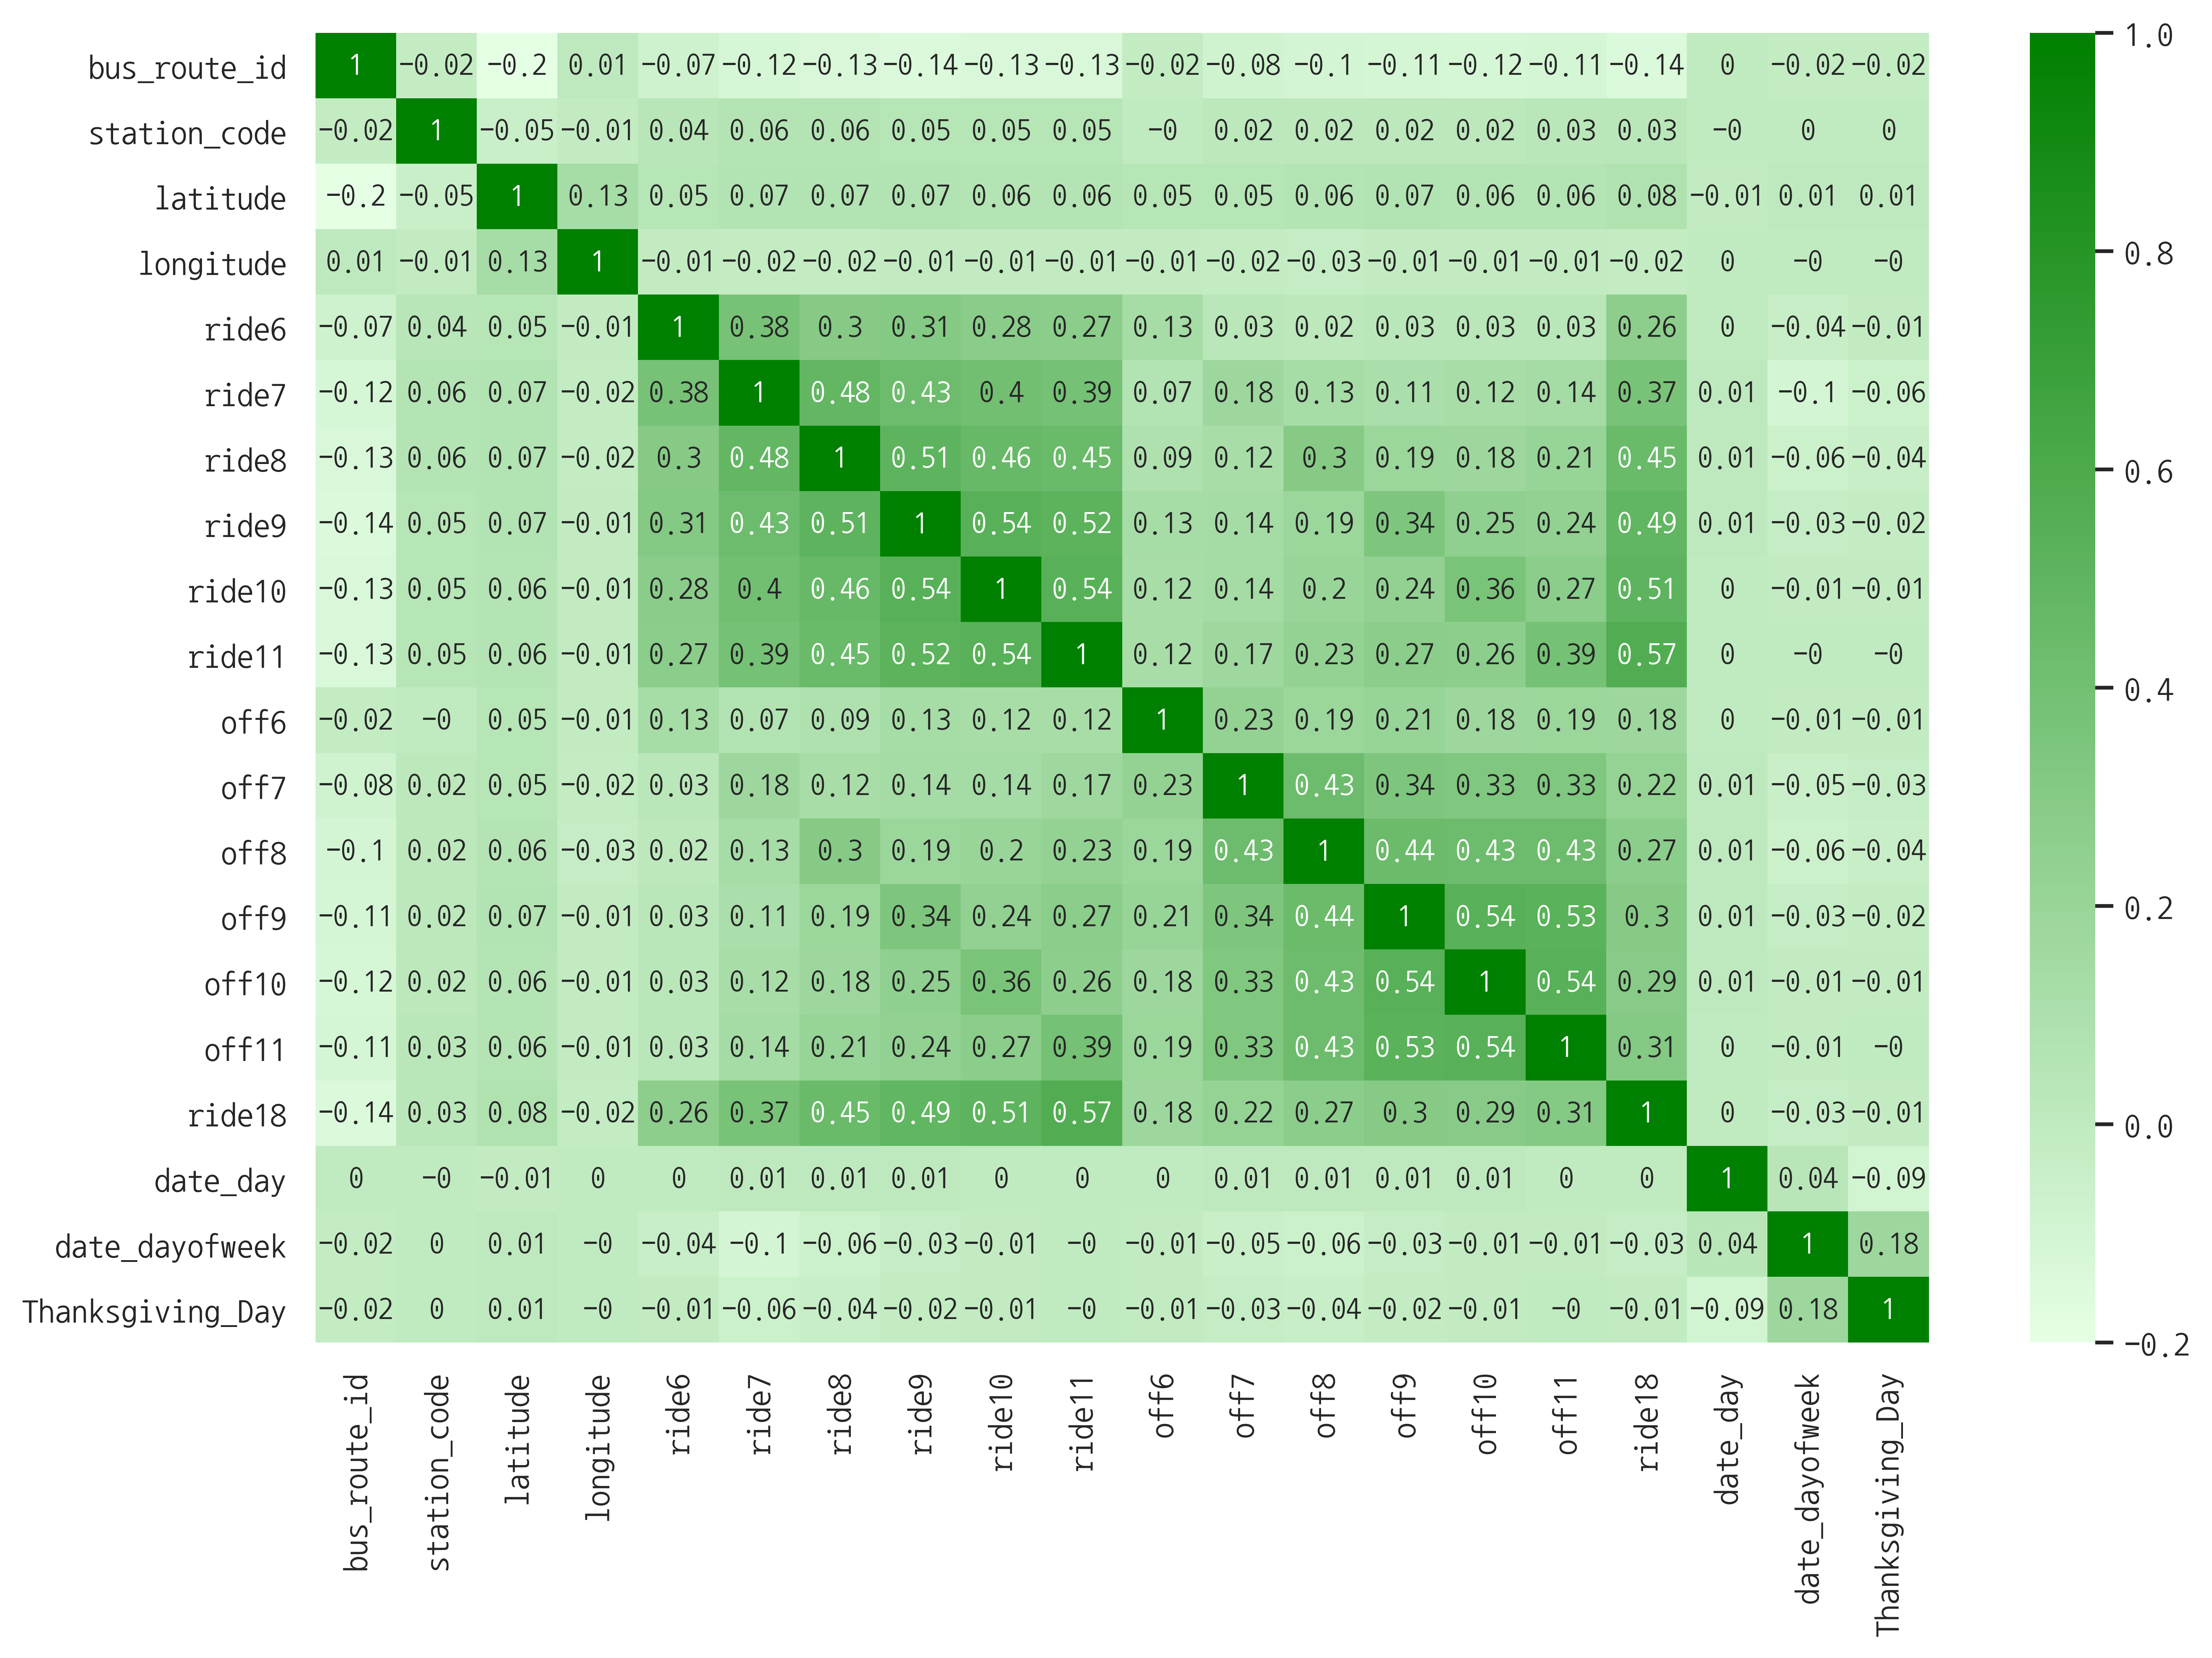

In [358]:
# 상관계수의 heatmap 화
plt.figure(figsize=(12, 8))
sns.heatmap(train_corr, annot=True, cmap=sns.light_palette("green", as_cmap=True))
plt.show()

In [89]:
# 모델에 넣을 변수만 저장
var = ['latitude', 'longitude', 'ride6', 'ride7', 'ride8',
       'ride9', 'ride10', 'ride11', 'off6', 'off7', 'off8', 'off9', 'off10',
       'off11', 'date_day', 'date_dayofweek']
cate = ['in_out','Thanksgiving_Day']

In [91]:
# scale변수로 변경
var_scale = ["scale({})".format(name) for name in var]
var_scale

['scale(latitude)',
 'scale(longitude)',
 'scale(ride6)',
 'scale(ride7)',
 'scale(ride8)',
 'scale(ride9)',
 'scale(ride10)',
 'scale(ride11)',
 'scale(off6)',
 'scale(off7)',
 'scale(off8)',
 'scale(off9)',
 'scale(off10)',
 'scale(off11)',
 'scale(date_day)',
 'scale(date_dayofweek)']

In [92]:
# 기본적인 내용만 OLS에 넣어봄
# 추석을 넣어도 0.444 이네요.
model = sm.OLS.from_formula(
    'ride18 ~ C(in_out) + C(Thanksgiving_Day) + '+'+'.join(var_scale), data=train)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                 ride18   R-squared:                       0.443
Model:                            OLS   Adj. R-squared:                  0.443
Method:                 Least Squares   F-statistic:                 1.837e+04
Date:                Mon, 23 Mar 2020   Prob (F-statistic):               0.00
Time:                        21:28:59   Log-Likelihood:            -1.1127e+06
No. Observations:              415423   AIC:                         2.225e+06
Df Residuals:                  415404   BIC:                         2.226e+06
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

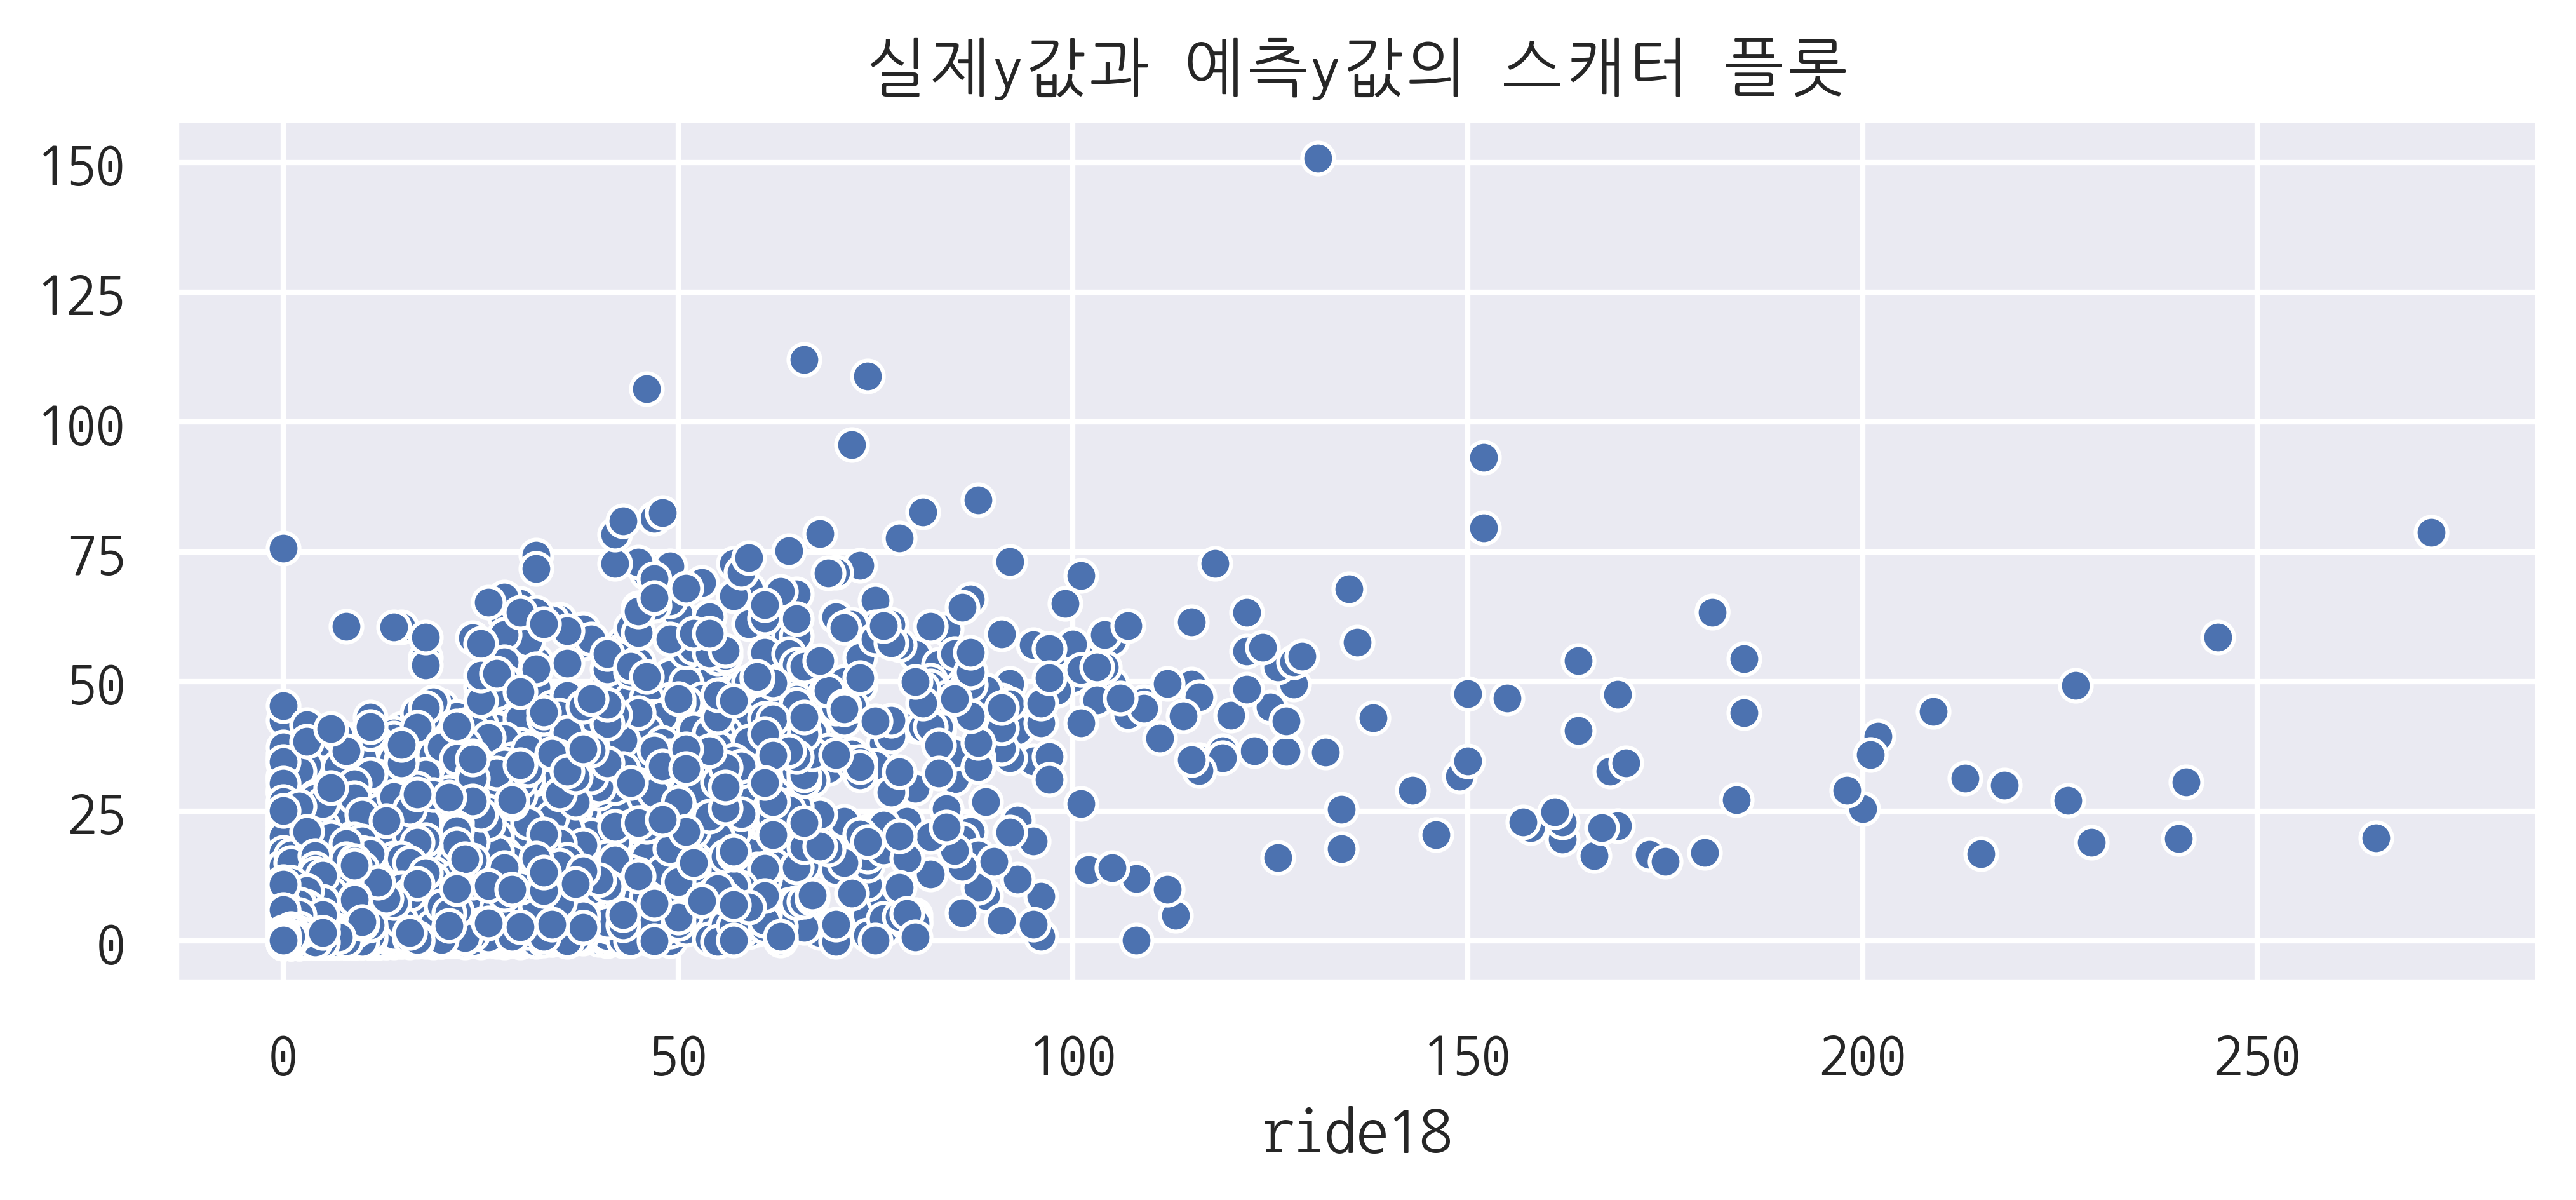

In [363]:
# R-squared : 0.443의 y값의 스캐터 플롯
# x를 scale 값으로 넣어야 하는건가?
y = result.predict()
x = train['ride18']
sns.scatterplot(x, y)
plt.title('실제y값과 예측y값의 스캐터 플롯')
plt.show()

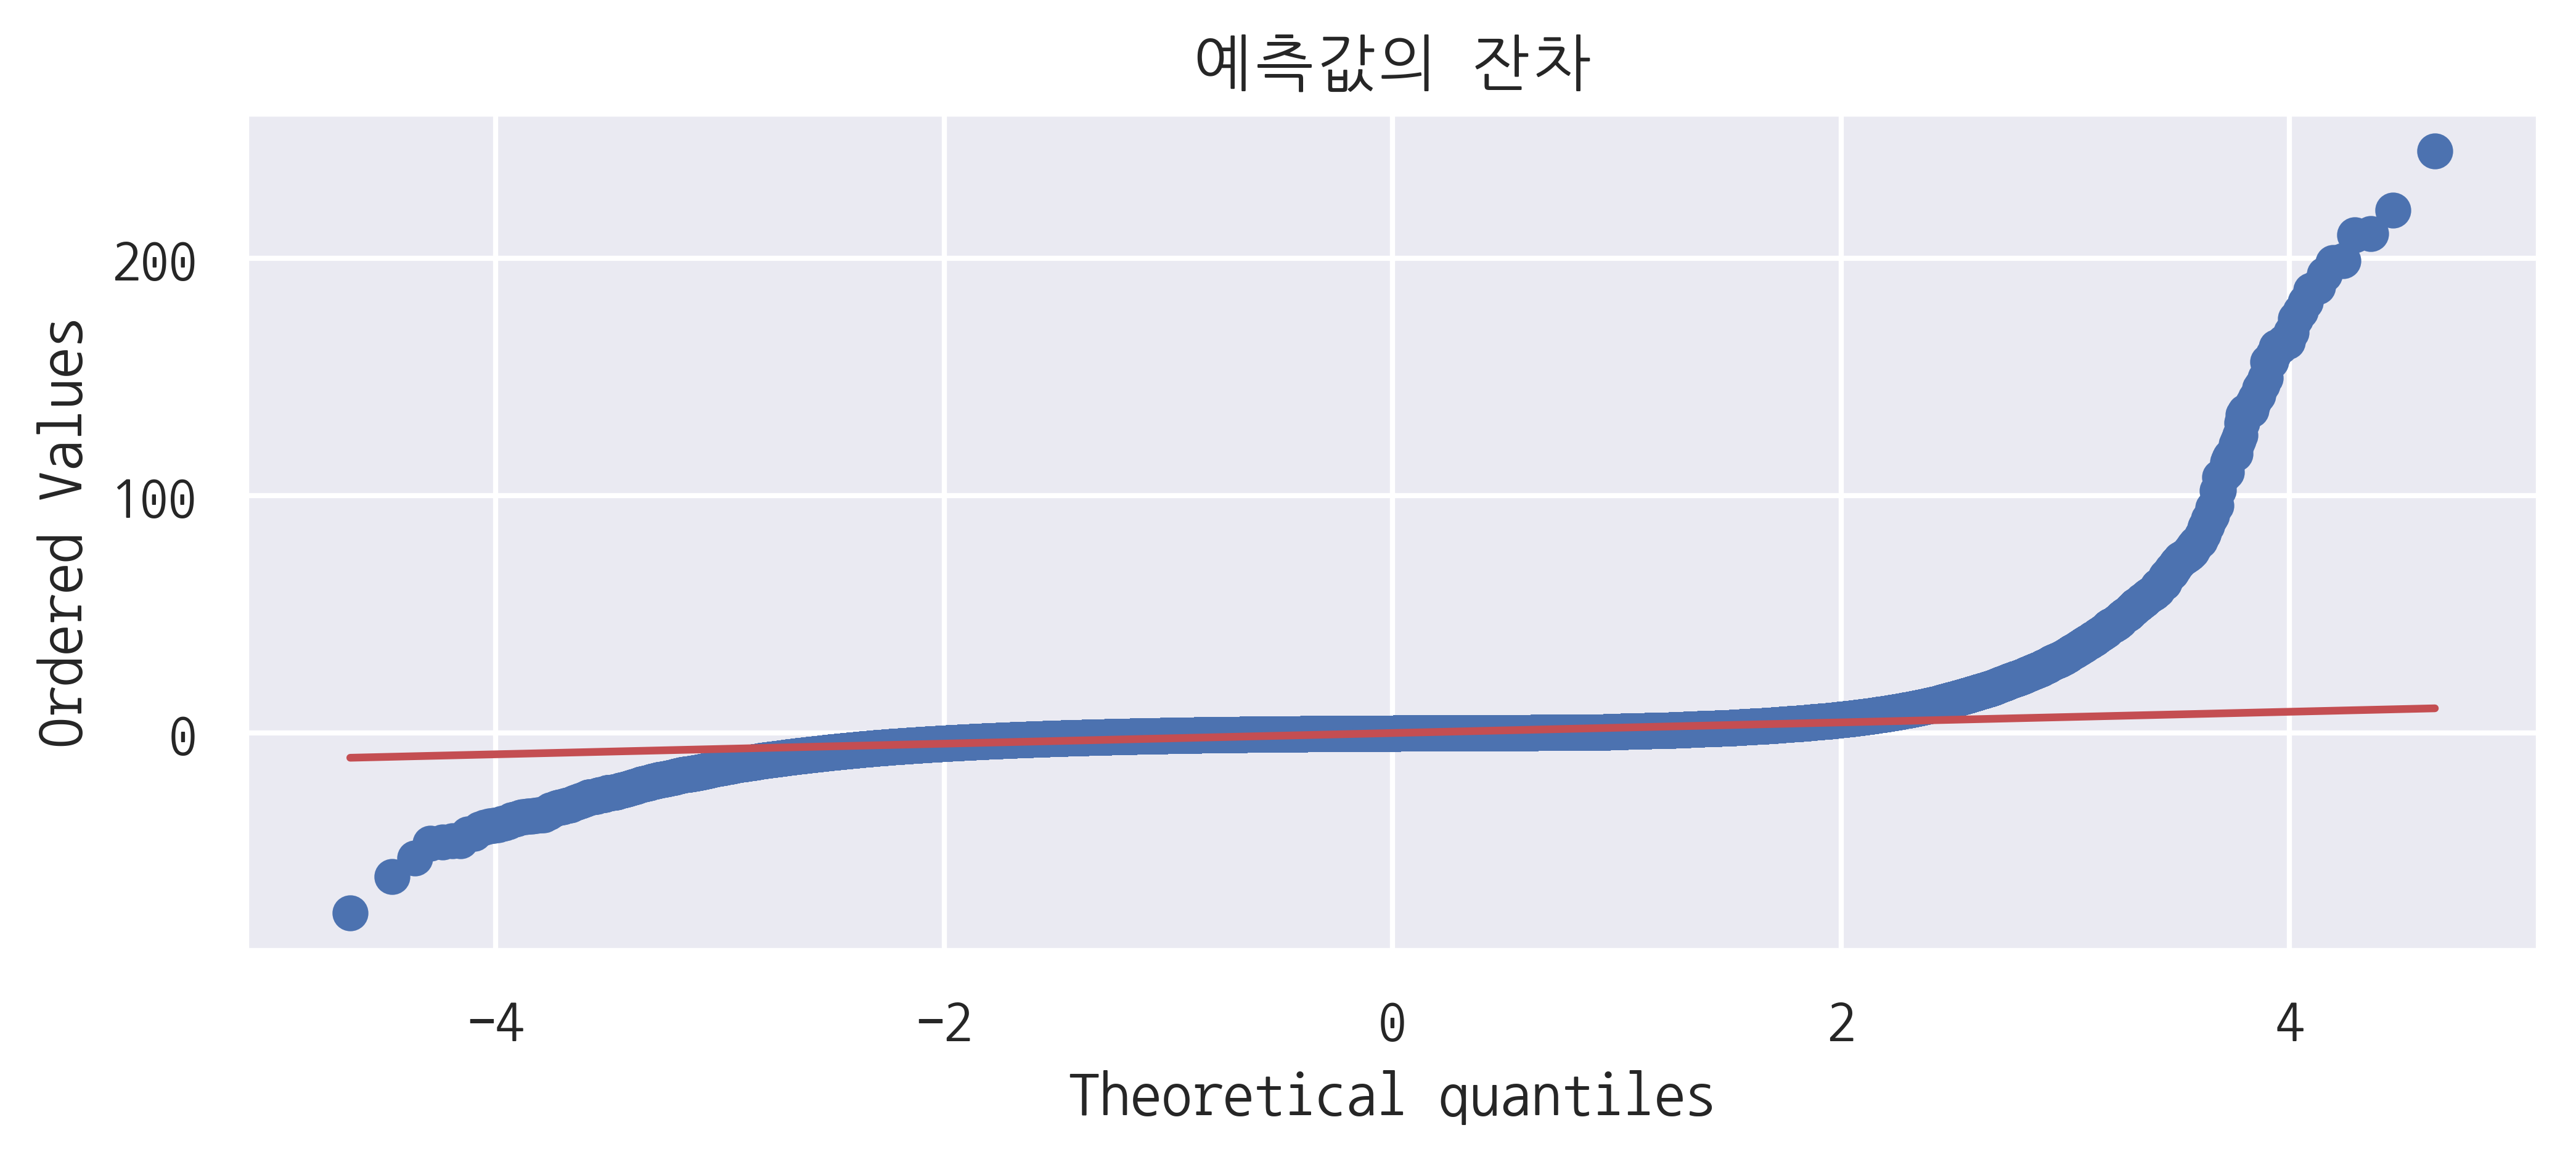

In [364]:
# 예측값의 잔차
# 데이터가 모형 가정을 따르지 않지만 잔차는 정규 분포를 따르는 것을 알 수 있다
sp.stats.probplot(result.resid, plot=plt)
plt.title('예측값의 잔차')
plt.show()

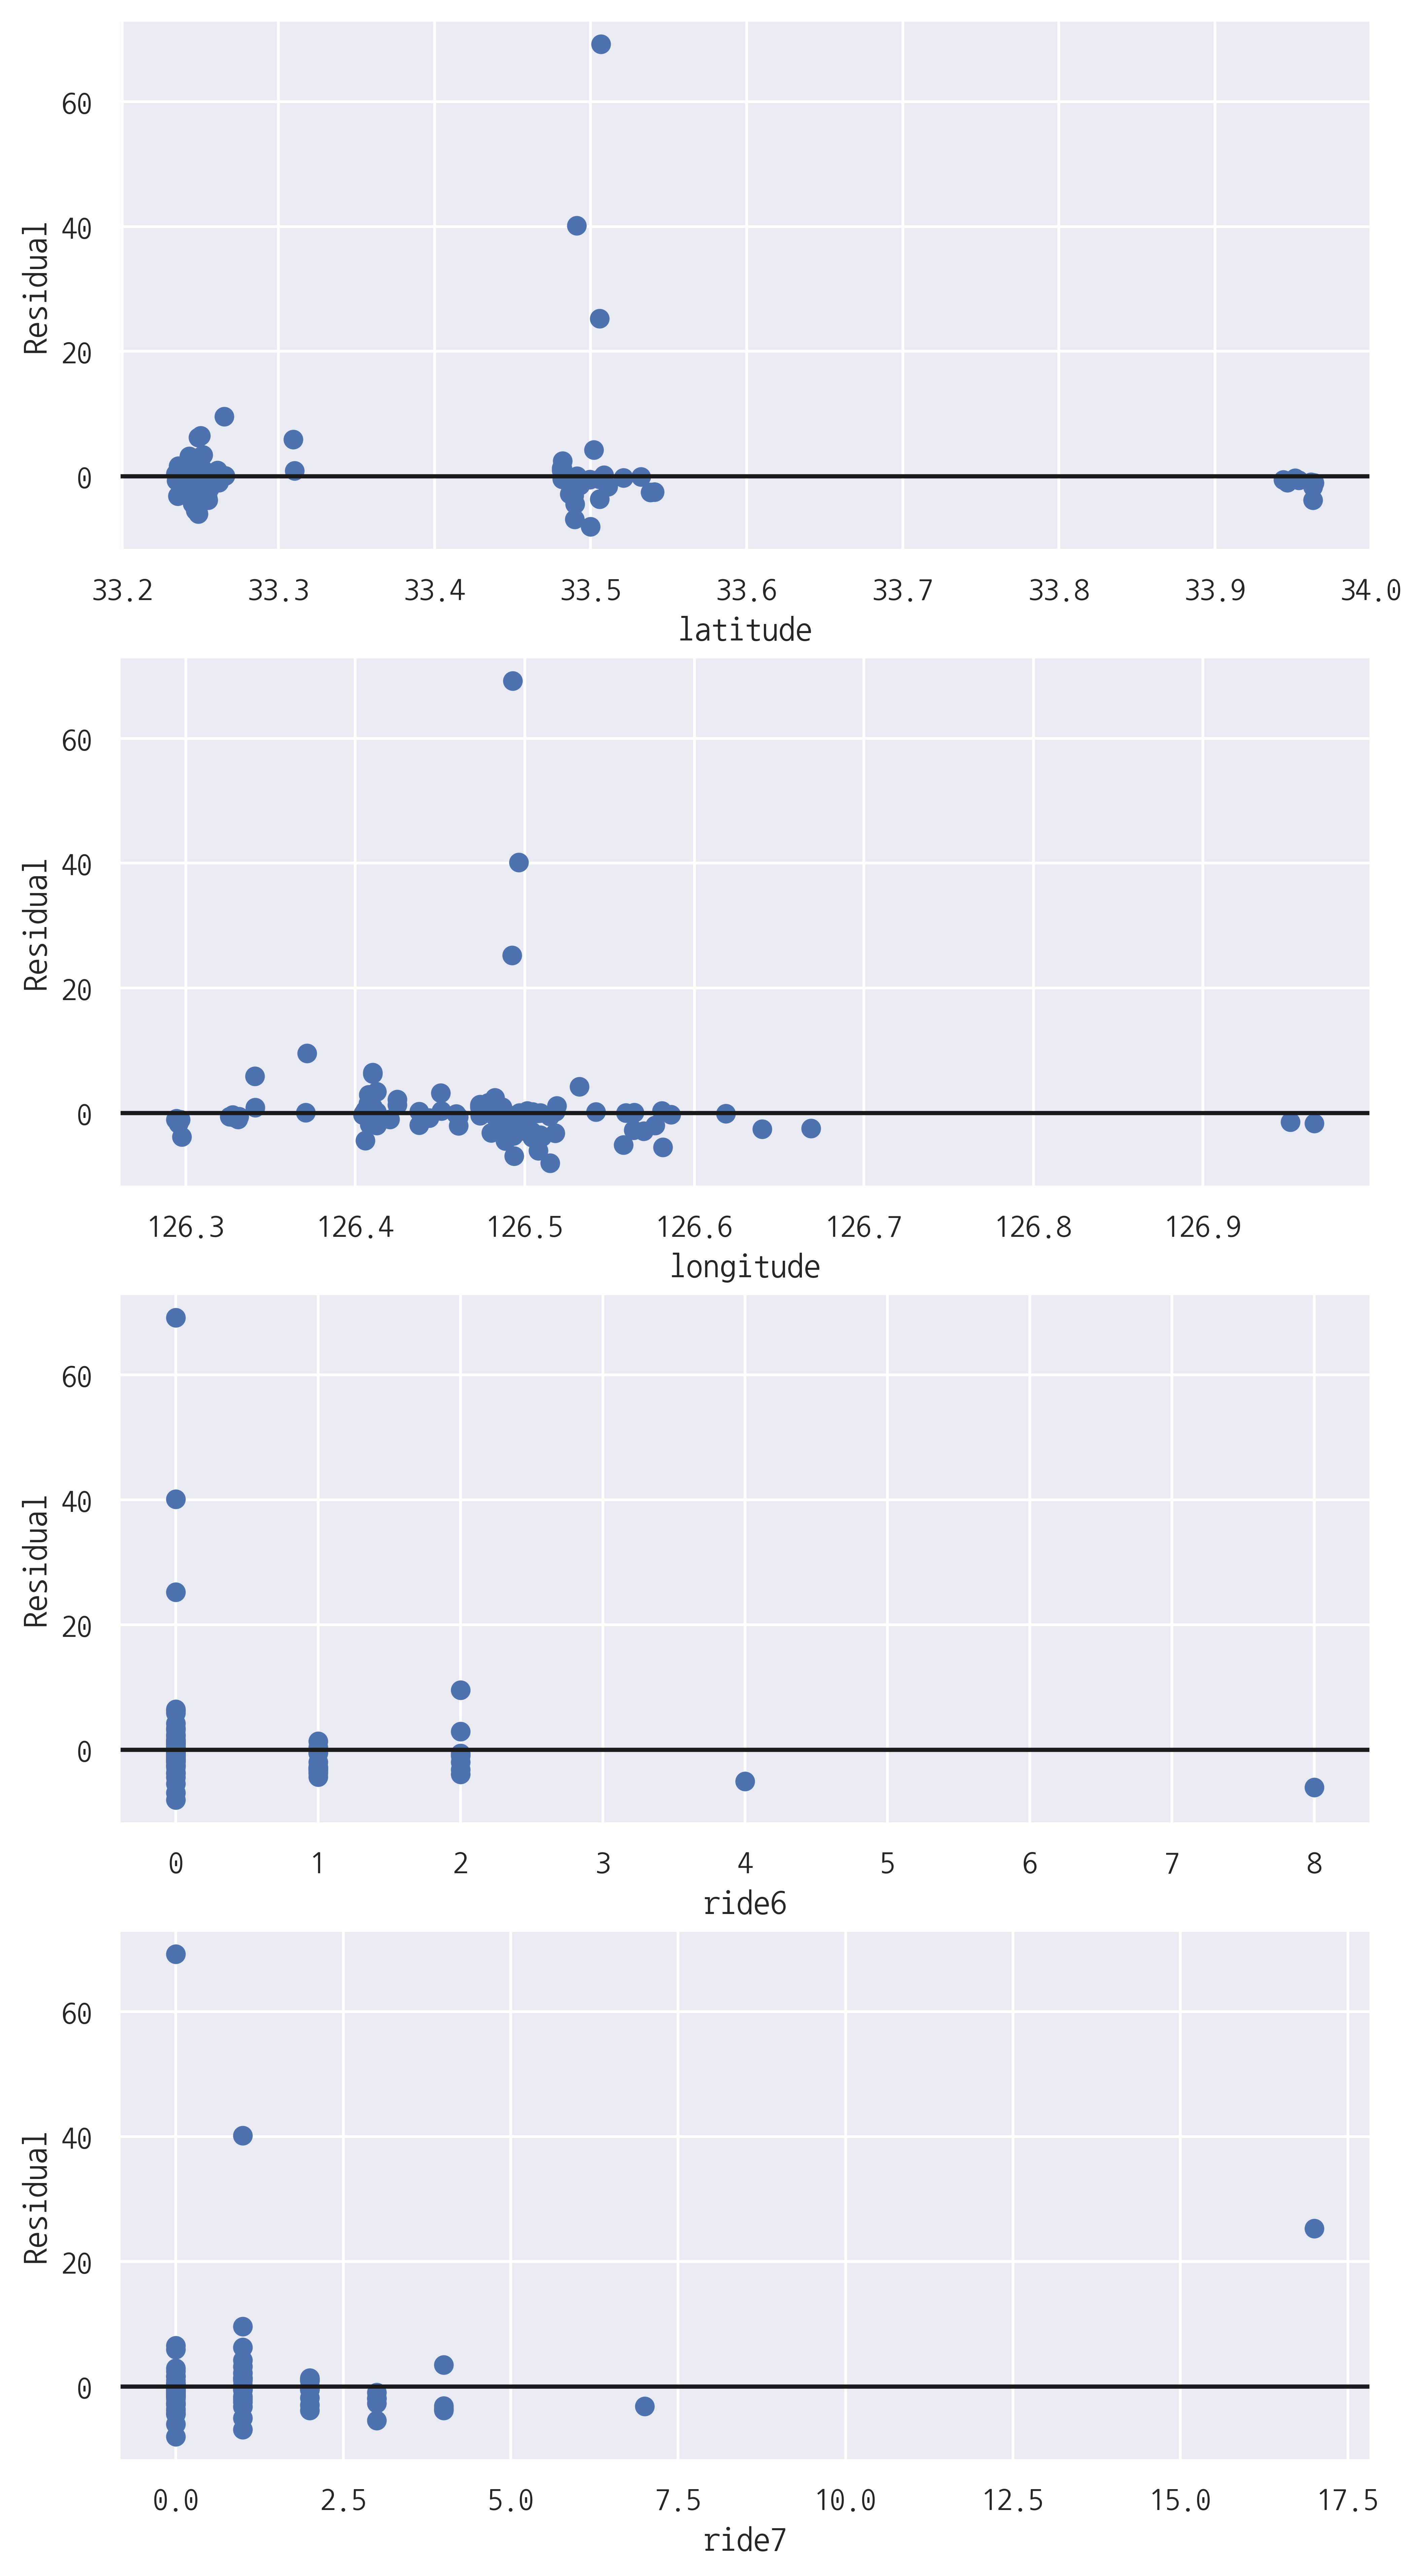

In [115]:
# 아래는 잔차와 독립변수간의 상관관계를 확인하는 그래프를 그리는중이였습니다.
# 나중에 OLS 하시고 변형하셔도 쓰셔도 될듯 합니다.
# 잔차와 독립변수간의 상관관계 확인
# 독립변수x를 스케일한 값으로 보아야하지않는가?

# plt.figure(figsize=(8,16))
# plt.subplot(411)
# plt.plot(train['latitude'][:100], result.resid[:100], 'o')
# plt.axhline(y=0, c='k')
# plt.xlabel("latitude")
# plt.ylabel("Residual")

# plt.subplot(412)
# plt.plot(train['longitude'][:100], result.resid[:100], 'o')
# plt.axhline(y=0, c='k')
# plt.xlabel("longitude")
# plt.ylabel("Residual")

# plt.subplot(413)
# plt.plot(train['ride6'][:100], result.resid[:100], 'o')
# plt.axhline(y=0, c='k')
# plt.xlabel("ride6")
# plt.ylabel("Residual")

# plt.subplot(414)
# plt.plot(train['ride7'][:100], result.resid[:100], 'o')
# plt.axhline(y=0, c='k')
# plt.xlabel("ride7")
# plt.ylabel("Residual")

# plt.tight_layout
# plt.show()

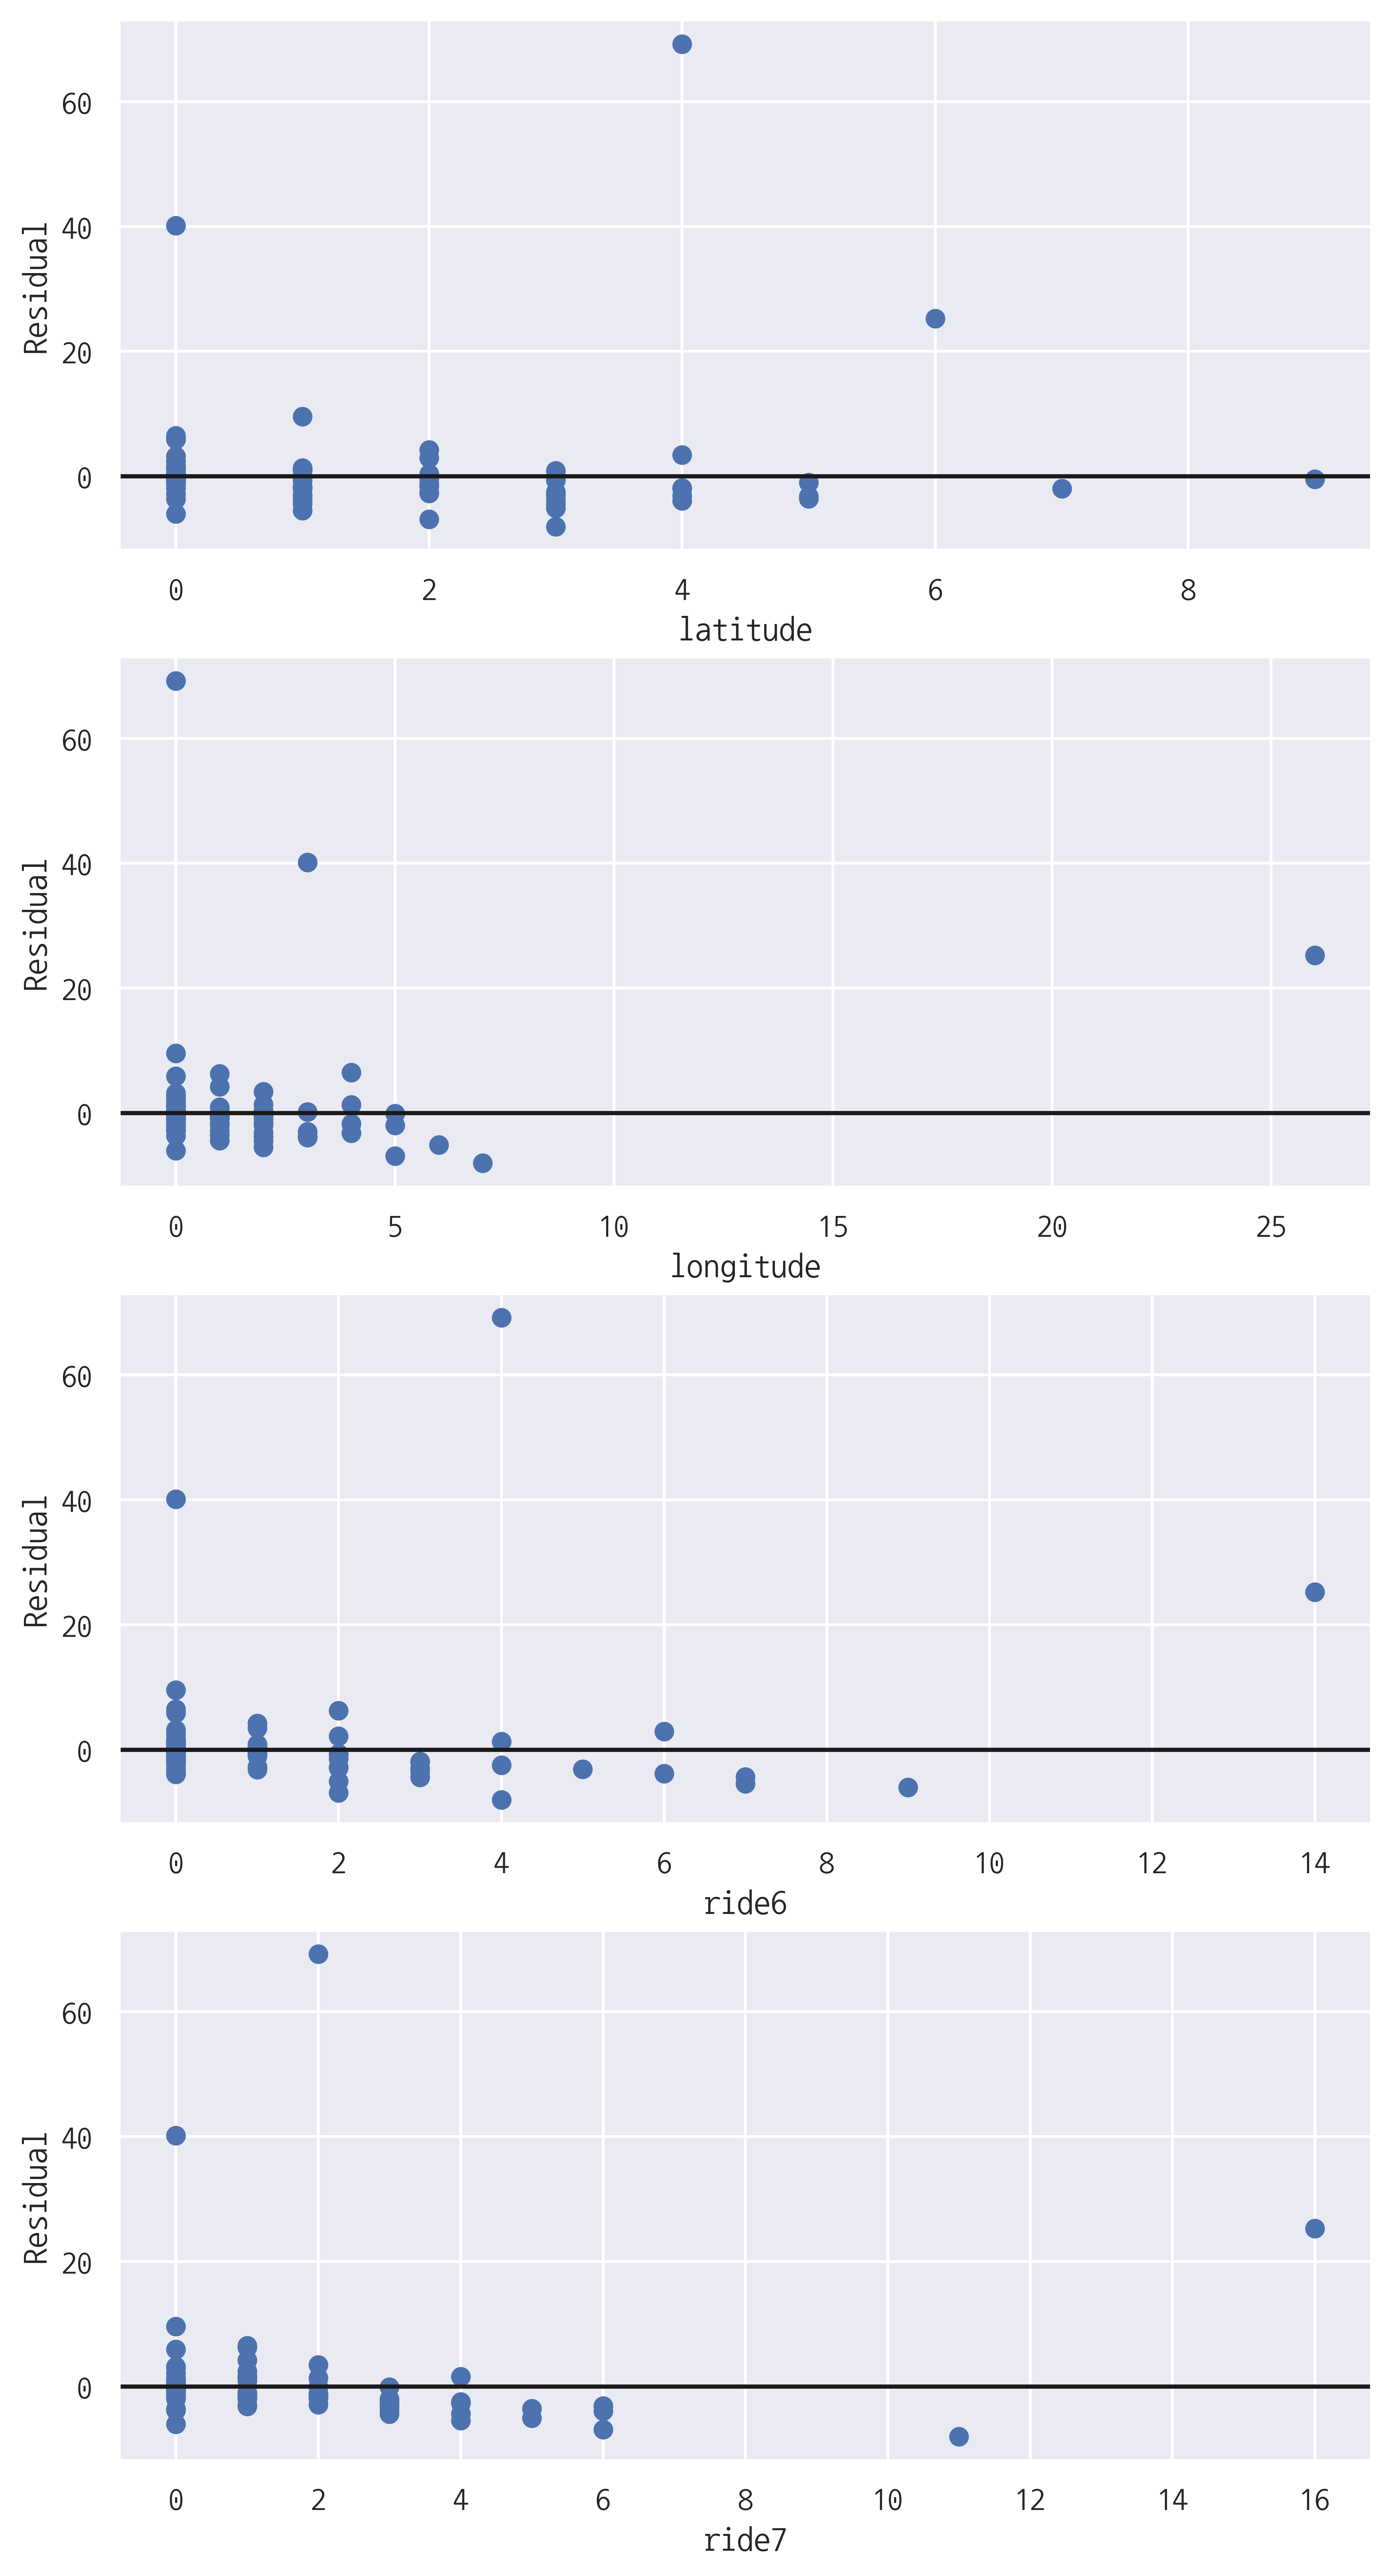

In [116]:
# plt.figure(figsize=(8,16))
# plt.subplot(411)
# plt.plot(train['ride8'][:100], result.resid[:100], 'o')
# plt.axhline(y=0, c='k')
# plt.xlabel("latitude")
# plt.ylabel("Residual")

# plt.subplot(412)
# plt.plot(train['ride9'][:100], result.resid[:100], 'o')
# plt.axhline(y=0, c='k')
# plt.xlabel("longitude")
# plt.ylabel("Residual")

# plt.subplot(413)
# plt.plot(train['ride10'][:100], result.resid[:100], 'o')
# plt.axhline(y=0, c='k')
# plt.xlabel("ride6")
# plt.ylabel("Residual")

# plt.subplot(414)
# plt.plot(train['ride11'][:100], result.resid[:100], 'o')
# plt.axhline(y=0, c='k')
# plt.xlabel("ride7")
# plt.ylabel("Residual")

# plt.tight_layout
# plt.show()

In [365]:
# 여기아래부터 코드 작성해주세요.
# 중간에 적으면 알아보기 힘듬..

In [93]:
train.columns

Index(['date', 'bus_route_id', 'in_out', 'station_code', 'station_name',
       'latitude', 'longitude', 'ride6', 'ride7', 'ride8', 'ride9', 'ride10',
       'ride11', 'off6', 'off7', 'off8', 'off9', 'off10', 'off11', 'ride18',
       'date_day', 'date_dayofweek', 'date_dayofname', 'Thanksgiving_Day'],
      dtype='object')

In [282]:
import geopy.distance

coords_jejusi = (33.500770, 126.522761) #제주시의 위도 경도
coords_seoquipo = (33.259429, 126.558217) #서귀포시의 위도 경도
train['dis_jejusi'] = [geopy.distance.vincenty((train['latitude'].iloc[i],train['longitude'].iloc[i]), coords_jejusi).km for i in range(len(train))]
train['dis_seoquipo'] = [geopy.distance.vincenty((train['latitude'].iloc[i],train['longitude'].iloc[i]), coords_seoquipo).km for i in range(len(train))]

In [136]:
cols = list(train.columns)

In [137]:
cate = ['in_out','Thanksgiving_Day','date_dayofweek']
unnecessary = ['date','bus_route_id','station_code','station_name','latitude','longitude','date_day','date_dayofname','ride18']
[cols.remove(cat) for cat in cate]
[cols.remove(un) for un in unnecessary]
cols

['ride6',
 'ride7',
 'ride8',
 'ride9',
 'ride10',
 'ride11',
 'off6',
 'off7',
 'off8',
 'off9',
 'off10',
 'off11',
 'dis_jejusi',
 'dis_seoquipo']

In [138]:
cols

['ride6',
 'ride7',
 'ride8',
 'ride9',
 'ride10',
 'ride11',
 'off6',
 'off7',
 'off8',
 'off9',
 'off10',
 'off11',
 'dis_jejusi',
 'dis_seoquipo']

In [139]:
var = cols
var_scale = ["scale({})".format(name) for name in var]
var_scale

['scale(ride6)',
 'scale(ride7)',
 'scale(ride8)',
 'scale(ride9)',
 'scale(ride10)',
 'scale(ride11)',
 'scale(off6)',
 'scale(off7)',
 'scale(off8)',
 'scale(off9)',
 'scale(off10)',
 'scale(off11)',
 'scale(dis_jejusi)',
 'scale(dis_seoquipo)']

In [140]:
type(train.dis_jejusi[0])

numpy.float64

In [141]:
model = sm.OLS.from_formula(
    'ride18 ~ C(in_out) + C(Thanksgiving_Day) + '+'+'.join(var_scale), data=train)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                 ride18   R-squared:                       0.444
Model:                            OLS   Adj. R-squared:                  0.444
Method:                 Least Squares   F-statistic:                 2.074e+04
Date:                Mon, 23 Mar 2020   Prob (F-statistic):               0.00
Time:                        21:49:30   Log-Likelihood:            -1.1124e+06
No. Observations:              415423   AIC:                         2.225e+06
Df Residuals:                  415406   BIC:                         2.225e+06
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [158]:
model = sm.OLS.from_formula(
    'ride18 ~ C(date_dayofweek) + C(Thanksgiving_Day) + '+'+'.join(var_scale), data=train)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                 ride18   R-squared:                       0.444
Model:                            OLS   Adj. R-squared:                  0.444
Method:                 Least Squares   F-statistic:                 1.583e+04
Date:                Mon, 23 Mar 2020   Prob (F-statistic):               0.00
Time:                        22:24:58   Log-Likelihood:            -1.1122e+06
No. Observations:              415423   AIC:                         2.224e+06
Df Residuals:                  415401   BIC:                         2.225e+06
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [163]:
scale(train.ride6)

NameError: name 'scale' is not defined

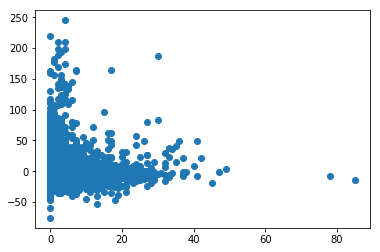

In [160]:
plt.scatter(train.ride6,result.resid)

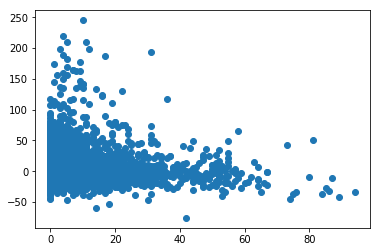

In [161]:
plt.scatter(train.ride7,result.resid)

### 문제 : 전체적으로 계수가 너무 낮다.

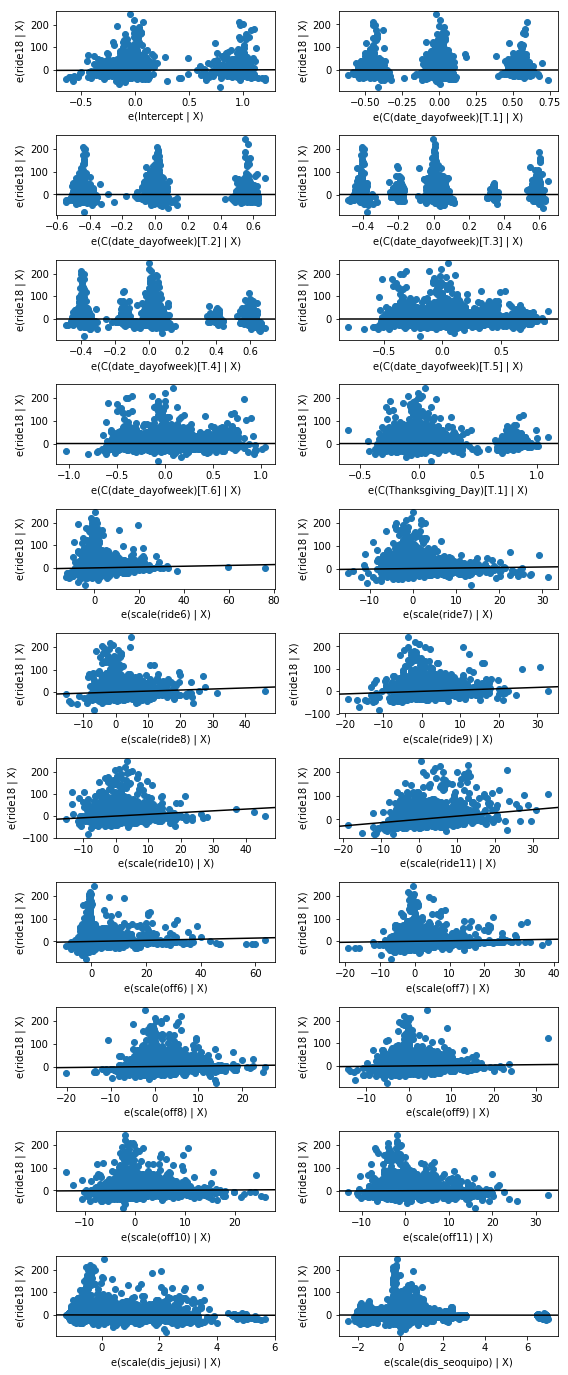

In [143]:
fig = plt.figure(figsize=(8, 20))
sm.graphics.plot_partregress_grid(result, fig=fig)
fig.suptitle("")
plt.show()

### 대부분의 실수 변수만의 부분회귀 잔차에 ㄴ자 관계가 남아있음 1/x항 추가(망함)

In [144]:
'+'.join(var_scale)

'scale(ride6)+scale(ride7)+scale(ride8)+scale(ride9)+scale(ride10)+scale(ride11)+scale(off6)+scale(off7)+scale(off8)+scale(off9)+scale(off10)+scale(off11)+scale(dis_jejusi)+scale(dis_seoquipo)'

In [151]:
log_scale = ["np.log(scale({})+1)".format(name) for name in var]
'+'.join(log_scale)

'np.log(scale(ride6)+1)+np.log(scale(ride7)+1)+np.log(scale(ride8)+1)+np.log(scale(ride9)+1)+np.log(scale(ride10)+1)+np.log(scale(ride11)+1)+np.log(scale(off6)+1)+np.log(scale(off7)+1)+np.log(scale(off8)+1)+np.log(scale(off9)+1)+np.log(scale(off10)+1)+np.log(scale(off11)+1)+np.log(scale(dis_jejusi)+1)+np.log(scale(dis_seoquipo)+1)'

In [152]:
'+'.join(var_scale)+ '+'.join(log_scale)

'scale(ride6)+scale(ride7)+scale(ride8)+scale(ride9)+scale(ride10)+scale(ride11)+scale(off6)+scale(off7)+scale(off8)+scale(off9)+scale(off10)+scale(off11)+scale(dis_jejusi)+scale(dis_seoquipo)np.log(scale(ride6)+1)+np.log(scale(ride7)+1)+np.log(scale(ride8)+1)+np.log(scale(ride9)+1)+np.log(scale(ride10)+1)+np.log(scale(ride11)+1)+np.log(scale(off6)+1)+np.log(scale(off7)+1)+np.log(scale(off8)+1)+np.log(scale(off9)+1)+np.log(scale(off10)+1)+np.log(scale(off11)+1)+np.log(scale(dis_jejusi)+1)+np.log(scale(dis_seoquipo)+1)'

In [153]:
model = sm.OLS.from_formula(
    'ride18 ~ C(date_dayofweek) + C(Thanksgiving_Day) + '+'+'.join(var_scale)+'+' + '+'.join(log_scale), data=train)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                 ride18   R-squared:                       0.389
Model:                            OLS   Adj. R-squared:                  0.389
Method:                 Least Squares   F-statistic:                     4869.
Date:                Mon, 23 Mar 2020   Prob (F-statistic):               0.00
Time:                        22:13:52   Log-Likelihood:            -7.3228e+05
No. Observations:              267308   AIC:                         1.465e+06
Df Residuals:                  267272   BIC:                         1.465e+06
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In [157]:
len(train.ride6), len(result.resid)

(415423, 267308)

ValueError: x and y must be the same size

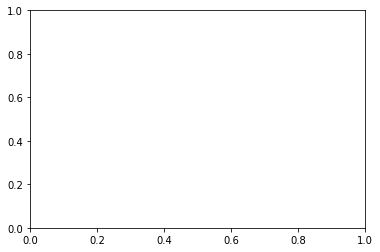

In [155]:
plt.scatter(train.ride6, result.resid)

In [283]:
train.columns

Index(['date', 'bus_route_id', 'in_out', 'station_code', 'station_name',
       'latitude', 'longitude', 'ride6', 'ride7', 'ride8', 'ride9', 'ride10',
       'ride11', 'off6', 'off7', 'off8', 'off9', 'off10', 'off11', 'ride18',
       'date_day', 'date_dayofweek', 'date_dayofname', 'dis_jejusi',
       'dis_seoquipo'],
      dtype='object')

### 제주 날씨 데이터

In [268]:
train

id       date  bus_route_id in_out  station_code  \
0       0      2019-09-01  4270000       시외     344            
1       1      2019-09-01  4270000       시외     357            
2       2      2019-09-01  4270000       시외     432            
3       3      2019-09-01  4270000       시내     1579           
4       4      2019-09-01  4270000       시내     1646           
5       5      2019-09-01  4270000       시내     1648           
6       6      2019-09-01  4270000       시외     1660           
7       7      2019-09-01  4270000       시외     1666           
8       8      2019-09-01  4270000       시외     1726           
9       9      2019-09-01  4270000       시내     2008           
10      10     2019-09-01  4270000       시외     2009           
11      11     2019-09-01  4270000       시내     2013           
12      12     2019-09-01  4270000       시외     2014           
13      13     2019-09-01  4270000       시외     2094           
14      14     2019-09-01  4270000       시외     2095           
15      15     2019-09-01  4270000       시외     2114           
16      16     2019-09-01  4270000       시내     2494           
17      17     2019-09-01  4270000       시외     2697           
18      18     2019-09-01  4270000       시외     2699           
19      19     2019-09-01  4270000       시내     2843           
20      20     2019-09-01  4270000       시내     2851           
21      21     2019-09-01  4270000       시외     2885           
22      22     2019-09-01  4270000       시내     2966           
23      23     2019-09-01  4270000       시내     3031           
24      24     2019-09-01  4270000       시내     4154           
25      25     2019-09-01  4280000       시외     343            
26      26     2019-09-01  4280000       시내     358            
27      27     2019-09-01  4280000       시내     431            
28      28     2019-09-01  4280000       시내     1636           
29      29     2019-09-01  4280000       시내     1645           
...     ..            ...      ...       ..      ...           
415393  415393 2019-09-30  32760000      시내     122            
415394  415394 2019-09-30  32760000      시내     129            
415395  415395 2019-09-30  32760000      시내     136            
415396  415396 2019-09-30  32760000      시내     147            
415397  415397 2019-09-30  32760000      시내     164            
415398  415398 2019-09-30  32760000      시내     1261           
415399  415399 2019-09-30  32760000      시내     1629           
415400  415400 2019-09-30  32760000      시내     2522           
415401  415401 2019-09-30  32760000      시내     2645           
415402  415402 2019-09-30  32760000      시내     2650           
415403  415403 2019-09-30  32760000      시내     2651           
415404  415404 2019-09-30  32760000      시내     2969           
415405  415405 2019-09-30  32760000      시내     3271           
415406  415406 2019-09-30  32760000      시내     3273           
415407  415407 2019-09-30  32760000      시내     3275           
415408  415408 2019-09-30  32760000      시내     3279           
415409  415409 2019-09-30  32760000      시내     3281           
415410  415410 2019-09-30  32760000      시내     3289           
415411  415411 2019-09-30  32810000      시내     1129           
415412  415412 2019-09-30  32810000      시내     2468           
415413  415413 2019-09-30  32810000      시내     6115100        
415414  415414 2019-09-30  32820000      시내     96             
415415  415415 2019-09-30  32820000      시내     737            
415416  415416 2019-09-30  32820000      시내     786            
415417  415417 2019-09-30  32820000      시내     1080           
415418  415418 2019-09-30  32820000      시내     1129           
415419  415419 2019-09-30  32820000      시내     1564           
415420  415420 2019-09-30  32820000      시내     2322           
415421  415421 2019-09-30  32820000      시내     3291           
415422  415422 2019-09-30  32820000      시내     6115100        

                station_name  latitude  lon

In [30]:
weather = pd.read_csv('jejuweather.csv')

In [31]:
weather.tail()
# date 타입 변경
weather['date'] = weather['date'].astype('datetime64')
weather.columns 

Index(['date', 'temperature', 'amount of precipitation', 'wind speed',
       'humidity', 'atmospheric pressure'],
      dtype='object')

In [32]:
train = pd.merge(train, weather, on= 'date')

In [33]:
train.rename(columns={'amount of precipitation' : 'precipitation',
                      'wind speed':'wind_speed',
                      'atmospheric pressure':'atmospheric_pressure'},inplace=True)
train

date  bus_route_id in_out  station_code          station_name  \
0      2019-09-01  4270000       시외     344           제주썬호텔                  
1      2019-09-01  4270000       시외     357           한라병원                   
2      2019-09-01  4270000       시외     432           정존마을                   
3      2019-09-01  4270000       시내     1579          제주국제공항(600번)           
4      2019-09-01  4270000       시내     1646          중문관광단지입구               
5      2019-09-01  4270000       시내     1648          예래입구                   
6      2019-09-01  4270000       시외     1660          제주국제컨벤션센터중문대포해안주상절리대   
7      2019-09-01  4270000       시외     1666          창천리                    
8      2019-09-01  4270000       시외     1726          강정농협                   
9      2019-09-01  4270000       시내     2008          서귀포항                   
10     2019-09-01  4270000       시외     2009          뉴경남호텔                  
11     2019-09-01  4270000       시내     2013          신라호텔                   
12     2019-09-01  4270000       시외     2014          하얏트호텔                  
13     2019-09-01  4270000       시외     2094          한국콘도입구                 
14     2019-09-01  4270000       시외     2095          켄싱턴제주호텔입구              
15     2019-09-01  4270000       시외     2114          스위트호텔                  
16     2019-09-01  4270000       시내     2494          동광환승정류장5(서귀방면)         
17     2019-09-01  4270000       시외     2697          대포항                    
18     2019-09-01  4270000       시외     2699          약천사                    
19     2019-09-01  4270000       시내     2843          중문관광단지여미지식물원입구         
20     2019-09-01  4270000       시내     2851          제주월드컵경기장(600번)         
21     2019-09-01  4270000       시외     2885          월평마을                   
22     2019-09-01  4270000       시내     2966          롯데시티호텔(600번)           
23     2019-09-01  4270000       시내     3031          서귀포칼호텔(종점)             
24     2019-09-01  4270000       시내     4154          왕대왓                    
25     2019-09-01  4280000       시외     343           제주썬호텔                  
26     2019-09-01  4280000       시내     358           한라병원                   
27     2019-09-01  4280000       시내     431           정존마을                   
28     2019-09-01  4280000       시내     1636          롯데호텔                   
29     2019-09-01  4280000       시내     1645          중문관광단지입구               
...           ...      ...       ..      ...               ...               
415393 2019-09-30  32760000      시내     122           인다마을                   
415394 2019-09-30  32760000      시내     129           제주의료원                  
415395 2019-09-30  32760000      시내     136           산천단한국폴리텍대학             
415396 2019-09-30  32760000      시내     147           용천마을                   
415397 2019-09-30  32760000      시내     164           광양사거리                  
415398 2019-09-30  32760000      시내     1261          교래리                    
415399 2019-09-30  32760000      시내     1629          붉은오름휴양림입구              
415400 2019-09-30  32760000      시내     2522          남원읍사무소                 
415401 2019-09-30  32760000      시내     2645          디삘레                    
415402 2019-09-30  32760000      시내     2650          의귀교회앞                  
415403 2019-09-30  32760000      시내     2651          의귀환승정류장(의귀초등학교)        
415404 2019-09-30  32760000      시내     2969          제주버스터미널(종점)            
415405 2019-09-30  32760000      시내     3271          제주시청(광양방면)             
415406 2019-09-30  32760000      시내     3273          고산동산(광양방면)             
415407 2019-09-30  32760000      시내     3275          제주지방법원(광양방면)           
415408 2019-09-30  32760000      시내     3279          제주여자중고등학교(광양방면)        
415409 2019-09-30  32760000      시내     3281          남국원(광양방면)              
415410 2019-09-30  32760000      시내     3289          남원환승정류장(남원읍사무소)        
415411 2019-09-30  32810000      시내     1129          한림환승정류장(한림리)           
415412 2019-09-30  32810000      시내

In [34]:
train.columns

Index(['date', 'bus_route_id', 'in_out', 'station_code', 'station_name',
       'latitude', 'longitude', 'ride6', 'ride7', 'ride8', 'ride9', 'ride10',
       'ride11', 'off6', 'off7', 'off8', 'off9', 'off10', 'off11', 'ride18',
       'date_day', 'date_dayofweek', 'date_dayofname', 'Thanksgiving_Day',
       'temperature', 'precipitation', 'wind_speed', 'humidity',
       'atmospheric_pressure'],
      dtype='object')

In [35]:
df = train.copy()

In [36]:
df.columns

Index(['date', 'bus_route_id', 'in_out', 'station_code', 'station_name',
       'latitude', 'longitude', 'ride6', 'ride7', 'ride8', 'ride9', 'ride10',
       'ride11', 'off6', 'off7', 'off8', 'off9', 'off10', 'off11', 'ride18',
       'date_day', 'date_dayofweek', 'date_dayofname', 'Thanksgiving_Day',
       'temperature', 'precipitation', 'wind_speed', 'humidity',
       'atmospheric_pressure'],
      dtype='object')

In [37]:
cols = list(df.columns)
cate = ['in_out','Thanksgiving_Day','date_dayofweek']

[cols.remove(cat) for cat in cate]

cols

['date',
 'bus_route_id',
 'station_code',
 'station_name',
 'latitude',
 'longitude',
 'ride6',
 'ride7',
 'ride8',
 'ride9',
 'ride10',
 'ride11',
 'off6',
 'off7',
 'off8',
 'off9',
 'off10',
 'off11',
 'ride18',
 'date_day',
 'date_dayofname',
 'temperature',
 'precipitation',
 'wind_speed',
 'humidity',
 'atmospheric_pressure']

In [38]:
unnecessary = ['date','bus_route_id','station_code','station_name','latitude','longitude','date_day','date_dayofname','ride18']
[cols.remove(un) for un in unnecessary]
cols

['ride6',
 'ride7',
 'ride8',
 'ride9',
 'ride10',
 'ride11',
 'off6',
 'off7',
 'off8',
 'off9',
 'off10',
 'off11',
 'temperature',
 'precipitation',
 'wind_speed',
 'humidity',
 'atmospheric_pressure']

In [39]:
var = cols
# var.remove('precipitation')
var_scale = ["scale({})".format(name) for name in var]
var_scale

['scale(ride6)',
 'scale(ride7)',
 'scale(ride8)',
 'scale(ride9)',
 'scale(ride10)',
 'scale(ride11)',
 'scale(off6)',
 'scale(off7)',
 'scale(off8)',
 'scale(off9)',
 'scale(off10)',
 'scale(off11)',
 'scale(temperature)',
 'scale(precipitation)',
 'scale(wind_speed)',
 'scale(humidity)',
 'scale(atmospheric_pressure)']

In [323]:
model = sm.OLS.from_formula(
    'ride18 ~ +'+'C(date_dayofname) + C(Thanksgiving_Day) +'+'+'.join(var_scale), data=df)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                 ride18   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                 1.331e+04
Date:                Mon, 23 Mar 2020   Prob (F-statistic):               0.00
Time:                        23:38:46   Log-Likelihood:            -1.1121e+06
No. Observations:              415423   AIC:                         2.224e+06
Df Residuals:                  415397   BIC:                         2.225e+06
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

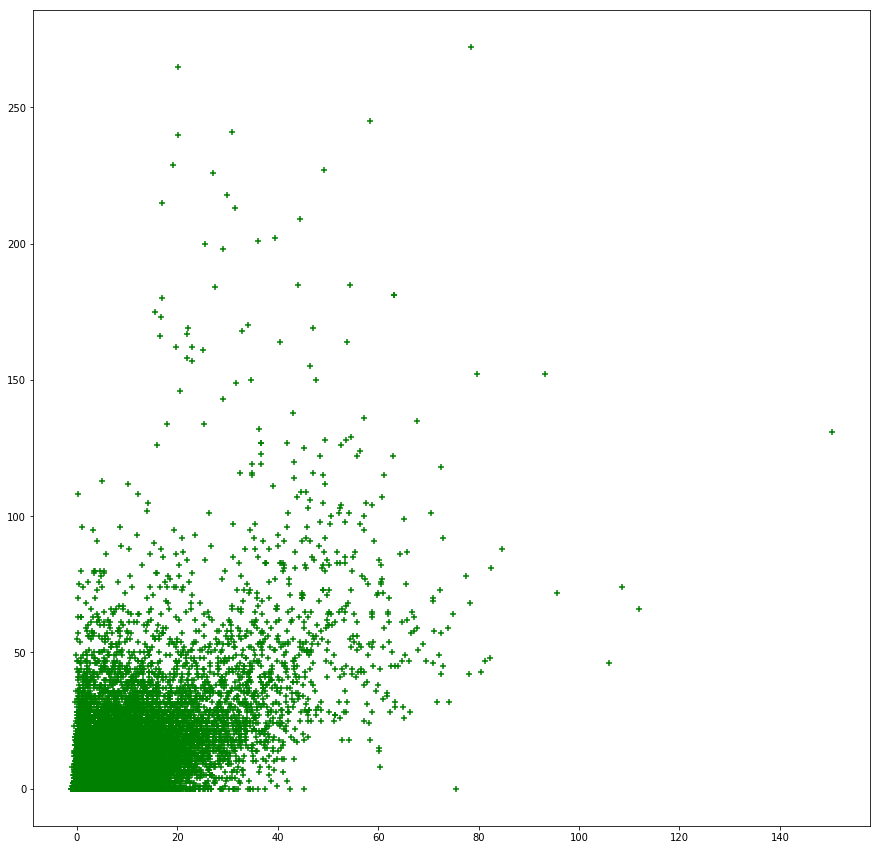

In [341]:
plt.figure(figsize = (15,15))
plt.scatter(result.predict(), df.ride18, marker = '+', c= 'g')
plt.show()

In [343]:
model = sm.OLS.from_formula(
    'np.log(ride18+1) ~ +'+'C(date_dayofname) + C(Thanksgiving_Day) +'+'+'.join(var_scale), data=df)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:     np.log(ride18 + 1)   R-squared:                       0.358
Model:                            OLS   Adj. R-squared:                  0.358
Method:                 Least Squares   F-statistic:                     9271.
Date:                Tue, 24 Mar 2020   Prob (F-statistic):               0.00
Time:                        00:06:48   Log-Likelihood:            -3.5346e+05
No. Observations:              415423   AIC:                         7.070e+05
Df Residuals:                  415397   BIC:                         7.072e+05
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

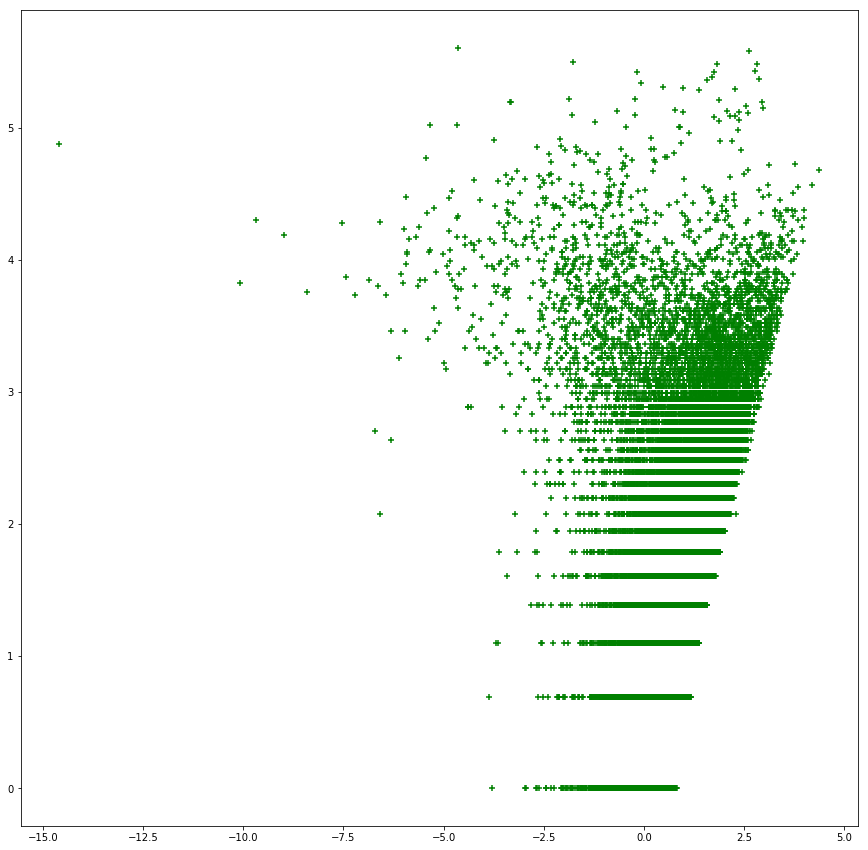

In [346]:
plt.figure(figsize = (15,15))
plt.scatter(result.resid, np.log(df.ride18), marker = '+', c= 'g')
plt.show()

In [351]:
result.resid.mean()

5.744233525290416e-16

In [354]:
len(df.station_code.unique())

3563

### 18시 탑승 상위10개 정류장에서의 거리 측정

In [40]:
table_ride18.sort_values('ride18', ascending = False).head(10)

ride18
station_name          
제주대학교          20103.0
제주시청(광양방면)     14206.0
한라병원           13944.0
제주시청(아라방면)     10375.0
동문로터리(동문시장)    9567.0 
제주버스터미널        9451.0 
제주국제공항(구제주방면)  9435.0 
제주도청신제주로터리     9398.0 
노형오거리          8803.0 
제주국제공항(신제주방면)  8216.0

In [48]:
train[train['station_name'] == '노형오거리'][['latitude', 'longitude']]

latitude  longitude
549     33.48666  126.48057
909     33.48666  126.48057
914     33.48521  126.47796
940     33.48667  126.48092
980     33.48666  126.48057
989     33.48667  126.48092
1294    33.48666  126.48057
1300    33.48521  126.47796
1360    33.48667  126.48092
1416    33.48666  126.48057
1422    33.48521  126.47796
1478    33.48667  126.48092
1529    33.48521  126.47796
1588    33.48503  126.48013
1617    33.48667  126.48092
1697    33.48503  126.48013
1728    33.48667  126.48092
2045    33.48503  126.48013
2166    33.48503  126.48013
2551    33.48667  126.48092
2600    33.48666  126.48057
3506    33.48503  126.48013
3533    33.48667  126.48092
3661    33.48667  126.48092
3921    33.48503  126.48013
3958    33.48667  126.48092
4618    33.48667  126.48092
4627    33.48521  126.47796
4671    33.48503  126.48013
4733    33.48503  126.48013
...          ...        ...
411282  33.48667  126.48092
411466  33.48667  126.48092
411654  33.48667  126.48092
411686  33.48666  126.48057
411710  33.48667  126.48092
413101  33.48666  126.48057
413107  33.48521  126.47796
413141  33.48667  126.48092
413174  33.48666  126.48057
413180  33.48521  126.47796
413204  33.48667  126.48092
413235  33.48666  126.48057
413236  33.48667  126.48092
413244  33.48521  126.47796
413279  33.48666  126.48057
413280  33.48667  126.48092
413883  33.48666  126.48057
413890  33.48521  126.47796
413943  33.48667  126.48092
414004  33.48666  126.48057
414009  33.48521  126.47796
414052  33.48667  126.48092
414099  33.48667  126.48092
414147  33.48666  126.48057
414148  33.48667  126.48092
414156  33.48521  126.47796
414562  33.48667  126.48092
414584  33.48666  126.48057
415045  33.48667  126.48092
415057  33.48666  126.48057

[2507 rows x 2 columns]

In [61]:
coords = {
'coords_jeju_uni' : (33.45589,126.55984), #제주대학교의 위도 경도
'coords_jeju_city1' : (33.49891,126.52822), #제주시청(광양방면)의 위도 경도
'coords_halla_hospital' : (33.48552,126.47533), #한라병원의 위도 경도
'coords_jeju_city2' : (33.49954,126.52765), #제주시청(아라방면)
'coords_jeju_rotary' : (33.51241,126.52595), #동문로터리(동문시장)의 위도 경도
'coords_jeju_bt' : (33.50298,126.49516), #제주버스터미널
'coords_jeju_airpt1' : (33.50618,126.49307), #제주국제공항(구제주방면)
'coords_nh' : (33.48493,126.47812), # 노형오거리의 위도 경도
'coords_jeju_airpt2' : (33.50650,126.49303) # 제주국제공항(신제주방면):
}

In [57]:
def get_distance(coords):
    distances = [geopy.distance.vincenty((train['latitude'].iloc[i],train['longitude'].iloc[i]), coords).km for i in range(len(train))]
    return distances

In [64]:
for i,j in coords.items():
    train[i] = get_distance(j)

In [66]:
train.head()

date  bus_route_id in_out  station_code  station_name  latitude  \
0 2019-09-01  4270000       시외     344           제주썬호텔         33.48990   
1 2019-09-01  4270000       시외     357           한라병원          33.48944   
2 2019-09-01  4270000       시외     432           정존마을          33.48181   
3 2019-09-01  4270000       시내     1579          제주국제공항(600번)  33.50577   
4 2019-09-01  4270000       시내     1646          중문관광단지입구      33.25579   

   longitude  ride6  ride7  ride8    ...      atmospheric_pressure  \
0  126.49373  0.0    1.0    2.0      ...      1014.3                 
1  126.48508  1.0    4.0    4.0      ...      1014.3                 
2  126.47352  1.0    1.0    0.0      ...      1014.3                 
3  126.49252  0.0    17.0   6.0      ...      1014.3                 
4  126.41260  0.0    0.0    0.0      ...      1014.3                 

   coords_halla_hospital  coords_jeju_city1  coords_jeju_uni  \
0  1.777683               3.357284           7.210437          
1  1.005035               4.144260           7.882664          
2  0.444545               5.425714           8.523410          
3  2.756127               3.403386           8.352000          
4  26.139788              29.031856          26.083610         

   coords_jeju_rotary  coords_jeju_bt  coords_jeju_city2  coords_jeju_airpt2  \
0  3.898320            1.456820        3.328526           1.842310             
1  4.573099            1.769946        4.111514           2.031282             
2  5.937689            3.091514        5.401146           3.284238             
3  3.192192            0.394882        3.336603           0.093815             
4  30.353305           28.472139       29.077183          28.796081            

   coords_jeju_airpt1  coords_nh  
0  1.806711            1.551929   
1  1.999639            0.817689   
2  3.256777            0.550025   
3  0.068407            2.670840   
4  28.762782           26.135361  

[5 rows x 38 columns]

In [75]:
df = train.copy()

In [76]:
df.columns

Index(['date', 'bus_route_id', 'in_out', 'station_code', 'station_name',
       'latitude', 'longitude', 'ride6', 'ride7', 'ride8', 'ride9', 'ride10',
       'ride11', 'off6', 'off7', 'off8', 'off9', 'off10', 'off11', 'ride18',
       'date_day', 'date_dayofweek', 'date_dayofname', 'Thanksgiving_Day',
       'temperature', 'precipitation', 'wind_speed', 'humidity',
       'atmospheric_pressure', 'coords_halla_hospital', 'coords_jeju_city1',
       'coords_jeju_uni', 'coords_jeju_rotary', 'coords_jeju_bt',
       'coords_jeju_city2', 'coords_jeju_airpt2', 'coords_jeju_airpt1',
       'coords_nh'],
      dtype='object')

In [77]:
cols = list(df.columns)
cate = ['in_out','Thanksgiving_Day','date_dayofweek']

[cols.remove(cat) for cat in cate]

cols

['date',
 'bus_route_id',
 'station_code',
 'station_name',
 'latitude',
 'longitude',
 'ride6',
 'ride7',
 'ride8',
 'ride9',
 'ride10',
 'ride11',
 'off6',
 'off7',
 'off8',
 'off9',
 'off10',
 'off11',
 'ride18',
 'date_day',
 'date_dayofname',
 'temperature',
 'precipitation',
 'wind_speed',
 'humidity',
 'atmospheric_pressure',
 'coords_halla_hospital',
 'coords_jeju_city1',
 'coords_jeju_uni',
 'coords_jeju_rotary',
 'coords_jeju_bt',
 'coords_jeju_city2',
 'coords_jeju_airpt2',
 'coords_jeju_airpt1',
 'coords_nh']

In [78]:
unnecessary = ['date','bus_route_id','station_code','station_name','latitude','longitude','date_day','date_dayofname','ride18','precipitation']
[cols.remove(un) for un in unnecessary]
cols

['ride6',
 'ride7',
 'ride8',
 'ride9',
 'ride10',
 'ride11',
 'off6',
 'off7',
 'off8',
 'off9',
 'off10',
 'off11',
 'temperature',
 'wind_speed',
 'humidity',
 'atmospheric_pressure',
 'coords_halla_hospital',
 'coords_jeju_city1',
 'coords_jeju_uni',
 'coords_jeju_rotary',
 'coords_jeju_bt',
 'coords_jeju_city2',
 'coords_jeju_airpt2',
 'coords_jeju_airpt1',
 'coords_nh']

In [79]:
var = cols
# var.remove('precipitation')
var_scale = ["scale({})".format(name) for name in var]
var_scale

['scale(ride6)',
 'scale(ride7)',
 'scale(ride8)',
 'scale(ride9)',
 'scale(ride10)',
 'scale(ride11)',
 'scale(off6)',
 'scale(off7)',
 'scale(off8)',
 'scale(off9)',
 'scale(off10)',
 'scale(off11)',
 'scale(temperature)',
 'scale(wind_speed)',
 'scale(humidity)',
 'scale(atmospheric_pressure)',
 'scale(coords_halla_hospital)',
 'scale(coords_jeju_city1)',
 'scale(coords_jeju_uni)',
 'scale(coords_jeju_rotary)',
 'scale(coords_jeju_bt)',
 'scale(coords_jeju_city2)',
 'scale(coords_jeju_airpt2)',
 'scale(coords_jeju_airpt1)',
 'scale(coords_nh)']

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 415423 entries, 0 to 415422
Data columns (total 38 columns):
date                     415423 non-null datetime64[ns]
bus_route_id             415423 non-null int64
in_out                   415423 non-null object
station_code             415423 non-null int64
station_name             415423 non-null object
latitude                 415423 non-null float64
longitude                415423 non-null float64
ride6                    415423 non-null float64
ride7                    415423 non-null float64
ride8                    415423 non-null float64
ride9                    415423 non-null float64
ride10                   415423 non-null float64
ride11                   415423 non-null float64
off6                     415423 non-null float64
off7                     415423 non-null float64
off8                     415423 non-null float64
off9                     415423 non-null float64
off10                    415423 non-null float64
off11 

In [81]:
model = sm.OLS.from_formula(
    'ride18 ~ +'+'C(date_dayofname) + C(Thanksgiving_Day) +'+'+'.join(var_scale), data=df)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                 ride18   R-squared:                       0.451
Model:                            OLS   Adj. R-squared:                  0.451
Method:                 Least Squares   F-statistic:                 1.067e+04
Date:                Tue, 24 Mar 2020   Prob (F-statistic):               0.00
Time:                        01:14:32   Log-Likelihood:            -1.1097e+06
No. Observations:              415423   AIC:                         2.219e+06
Df Residuals:                  415390   BIC:                         2.220e+06
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

### PCA를 통한 다중공선성 제거

In [131]:
len(X.columns)

25

In [89]:
X = df[cols]
Y = df.ride18

In [155]:
from sklearn.decomposition import PCA

pca1 = PCA(n_components=24)
X_low = pca1.fit_transform(X)

In [157]:
new_cols = []
for i in range(len(X_low.columns)):
    new_cols.append('comp{}'.format(i))
X_low.columns = new_cols

In [158]:
var = list(X_low.columns)
# var.remove('precipitation')
var_scale = ["scale({})".format(name) for name in var]
var_scale

['scale(comp0)',
 'scale(comp1)',
 'scale(comp2)',
 'scale(comp3)',
 'scale(comp4)',
 'scale(comp5)',
 'scale(comp6)',
 'scale(comp7)',
 'scale(comp8)',
 'scale(comp9)',
 'scale(comp10)',
 'scale(comp11)',
 'scale(comp12)',
 'scale(comp13)',
 'scale(comp14)',
 'scale(comp15)',
 'scale(comp16)',
 'scale(comp17)',
 'scale(comp18)',
 'scale(comp19)',
 'scale(comp20)',
 'scale(comp21)',
 'scale(comp22)',
 'scale(comp23)']

In [160]:
new_df = pd.concat([X_low, df[['ride18','date_dayofname','Thanksgiving_Day']]], join = 'outer', axis = 1)

In [161]:
len(new_df)

415423

In [162]:
new_df.head(3)

comp0     comp1     comp2     comp3     comp4     comp5     comp6  \
0 -38.253253  2.966273  3.376812  3.560406  3.930922 -1.297069 -0.164235   
1 -37.582397  2.998720  4.870096  3.963674  6.170848 -3.165385  0.042048   
2 -34.903381  2.948691  6.336245  3.811905 -1.143991 -1.441856  1.407899   

      comp7     comp8     comp9        ...           comp17    comp18  \
0  4.310448  0.010605 -0.869090        ...         0.985913  0.047381   
1  2.558735 -0.534557 -0.465921        ...         0.149520 -0.021137   
2  0.620364 -0.635661 -0.233042        ...        -0.004067 -0.228517   

     comp19    comp20    comp21    comp22    comp23  ride18  date_dayofname  \
0 -0.558423 -0.438324 -0.182267 -0.015823 -0.013407  0.0     Sunday           
1 -0.359820 -0.119271 -0.151085  0.050646 -0.002008  5.0     Sunday           
2  0.549230  0.429862 -0.040550 -0.021825 -0.002125  2.0     Sunday           

   Thanksgiving_Day  
0  0                 
1  0                 
2  0                 

[3 rows x 27 columns]

In [163]:
model = sm.OLS.from_formula(
    'ride18 ~ +'+'C(date_dayofname) + C(Thanksgiving_Day) +'+'+'.join(var_scale), data=new_df)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                 ride18   R-squared:                       0.451
Model:                            OLS   Adj. R-squared:                  0.451
Method:                 Least Squares   F-statistic:                 1.101e+04
Date:                Tue, 24 Mar 2020   Prob (F-statistic):               0.00
Time:                        01:49:03   Log-Likelihood:            -1.1097e+06
No. Observations:              415423   AIC:                         2.220e+06
Df Residuals:                  415391   BIC:                         2.220e+06
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

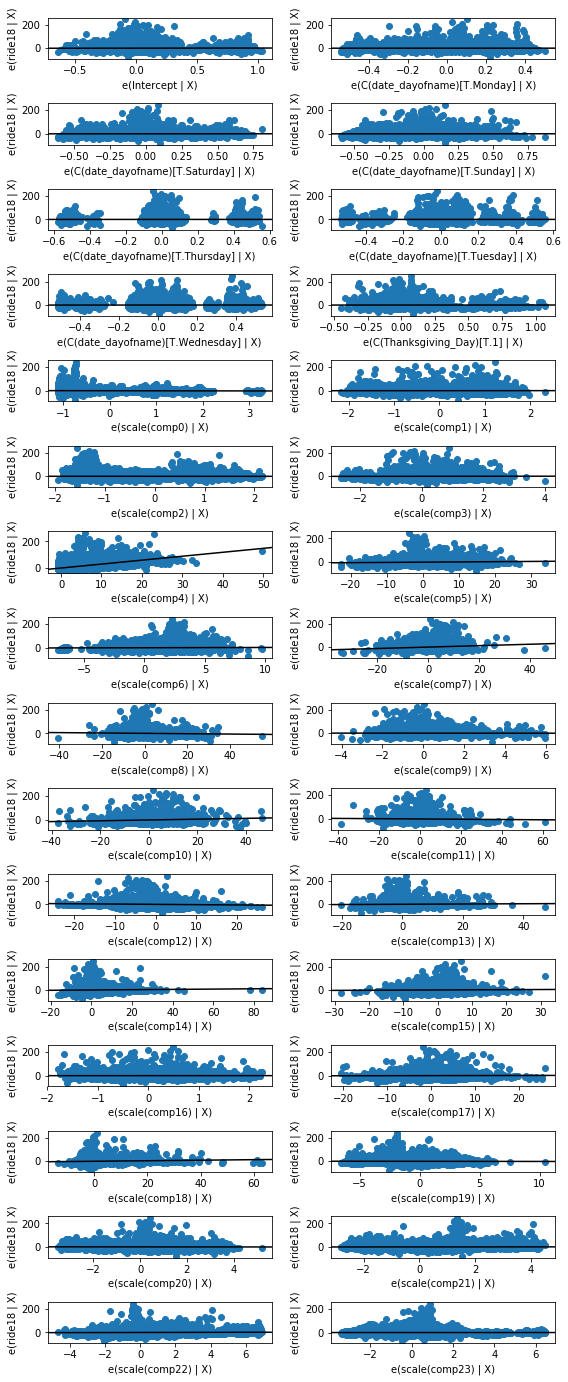

In [165]:
fig = plt.figure(figsize=(8, 20))
sm.graphics.plot_partregress_grid(result, fig=fig)
fig.suptitle("")
plt.show()

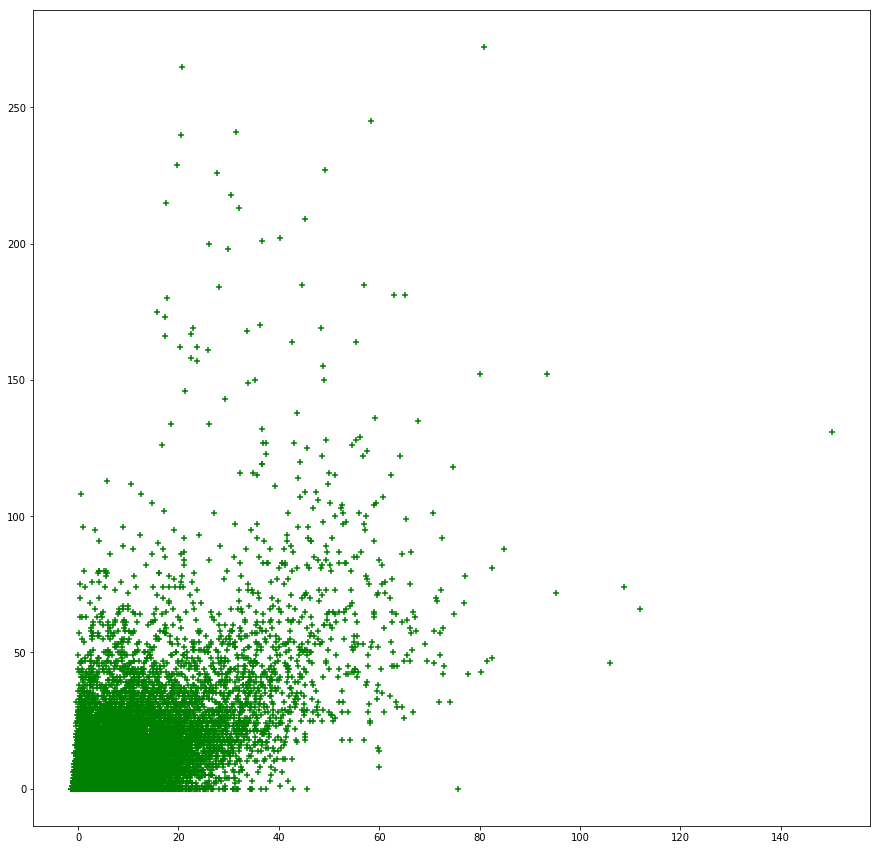

In [166]:
plt.figure(figsize = (15,15))
plt.scatter(result.predict(), df.ride18, marker = '+', c= 'g')
plt.show()

In [169]:
var_scale.pop(-1)

'scale(comp23)'

In [170]:
model = sm.OLS.from_formula(
    'ride18 ~ +'+'C(date_dayofname) + C(Thanksgiving_Day) +'+'+'.join(var_scale), data=new_df)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                 ride18   R-squared:                       0.451
Model:                            OLS   Adj. R-squared:                  0.451
Method:                 Least Squares   F-statistic:                 1.138e+04
Date:                Tue, 24 Mar 2020   Prob (F-statistic):               0.00
Time:                        02:38:11   Log-Likelihood:            -1.1097e+06
No. Observations:              415423   AIC:                         2.220e+06
Df Residuals:                  415392   BIC:                         2.220e+06
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   